In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_excel(r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx')


# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe(include='all'))

Dataset shape: (1866, 3)

First few rows:


,Disease,Count of Disease Occurrence,Symptom
0,UMLS:C0020538_hypertensive disease,3363.0,UMLS:C0008031_pain chest
1,NaN,NaN,UMLS:C0392680_shortness of breath
2,NaN,NaN,UMLS:C0012833_dizziness
3,NaN,NaN,UMLS:C0004093_asthenia
4,NaN,NaN,UMLS:C0085639_fall



Missing values per column:
Disease                        1732
Count of Disease Occurrence    1732
Symptom                           1
dtype: int64

Basic statistics:
                                   Disease  Count of Disease Occurrence  \
count                                  134                   134.000000   
unique                                 134                          NaN   
top     UMLS:C0020538_hypertensive disease                          NaN   
freq                                     1                          NaN   
mean                                   NaN                   251.671642   
std                                    NaN                   370.296767   
min                                    NaN                    42.000000   
25%                                    NaN                    90.000000   
50%                                    NaN                   141.000000   
75%                                    NaN                   268.750000   
max    

In [3]:
def clean_data(df):
    """
    Clean and preprocess the medical dataset
    """
    # Forward fill disease names and counts
    df['Disease'] = df['Disease'].ffill()
    df['Count of Disease Occurrence'] = df['Count of Disease Occurrence'].ffill()
    
    # Remove UMLS codes from disease names
    df['Disease'] = df['Disease'].str.replace(r'UMLS:[A-Za-z0-9_]+_', '', regex=True)
    df['Disease'] = df['Disease'].str.replace(r'\^UMLS:[A-Za-z0-9_]+', '', regex=True)
    
    # Remove UMLS codes from symptoms and split combined symptoms
    df['Symptom'] = df['Symptom'].str.replace(r'UMLS:[A-Za-z0-9_]+_', '', regex=True)
    df['Symptom'] = df['Symptom'].str.replace(r'\^UMLS:[A-Za-z0-9_]+', '', regex=True)
    df['Symptom'] = df['Symptom'].str.replace('_', ' ')
    
    # Clean symptom strings
    df['Symptom'] = df['Symptom'].str.lower().str.strip()
    
    # Drop rows with missing symptoms
    df = df.dropna(subset=['Symptom'])
    
    return df

# Apply cleaning
cleaned_df = clean_data(df.copy())

# Verify cleaning
print("\nCleaned data sample:")
display(cleaned_df.head())


Cleaned data sample:


,Disease,Count of Disease Occurrence,Symptom
0,hypertensive disease,3363.0,pain chest
1,hypertensive disease,3363.0,shortness of breath
2,hypertensive disease,3363.0,dizziness
3,hypertensive disease,3363.0,asthenia
4,hypertensive disease,3363.0,fall


In [4]:
# Disease-Symptom Data Cleaning & Output Generator

import pandas as pd
import re
import json
from collections import defaultdict

# 1. Load and Preprocess Data
def load_and_clean(file_path):
    df = pd.read_excel(file_path)
    
    # Forward fill diseases and counts
    df['Disease'] = df['Disease'].ffill()
    df['Count of Disease Occurrence'] = df['Count of Disease Occurrence'].ffill()

    # Clean disease names
    df['Disease'] = df['Disease'].apply(lambda x: re.sub(r'UMLS:[A-Za-z0-9_]+_', '', str(x)))
    df['Disease'] = df['Disease'].apply(lambda x: re.sub(r'\^UMLS:[A-Za-z0-9_]+', '', str(x)))

    # Clean symptoms
    df['Symptom'] = df['Symptom'].apply(lambda x: re.sub(r'UMLS:[A-Za-z0-9_]+_', '', str(x)))
    df['Symptom'] = df['Symptom'].apply(lambda x: re.sub(r'\^UMLS:[A-Za-z0-9_]+', '', str(x)))
    df['Symptom'] = df['Symptom'].str.replace('_', ' ').str.lower().str.strip()

    return df.dropna(subset=['Symptom'])

# 2. Create Structured Outputs
def create_structured_outputs(cleaned_df):
    disease_to_symptoms = defaultdict(list)
    for _, row in cleaned_df.iterrows():
        disease_to_symptoms[row['Disease']].append(row['Symptom'])
    disease_to_symptoms = {k: list(set(v)) for k, v in disease_to_symptoms.items()}

    symptom_to_diseases = defaultdict(list)
    for _, row in cleaned_df.iterrows():
        symptom_to_diseases[row['Symptom']].append(row['Disease'])
    symptom_to_diseases = {k: list(set(v)) for k, v in symptom_to_diseases.items()}

    diseases = sorted(disease_to_symptoms.keys())
    symptoms = sorted(symptom_to_diseases.keys())
    binary_matrix = pd.DataFrame(0, index=diseases, columns=symptoms)
    for disease, symptoms_list in disease_to_symptoms.items():
        for symptom in symptoms_list:
            binary_matrix.loc[disease, symptom] = 1

    edge_list = cleaned_df[['Disease', 'Symptom']].drop_duplicates()

    return {
        'disease_to_symptoms': dict(disease_to_symptoms),
        'symptom_to_diseases': dict(symptom_to_diseases),
        'binary_matrix': binary_matrix,
        'edge_list': edge_list
    }

# 3. Save Outputs
def save_outputs(outputs, base_filename):
    with open(f'{base_filename}_disease_symptoms.json', 'w') as f:
        json.dump(outputs['disease_to_symptoms'], f, indent=2)

    with open(f'{base_filename}_symptom_diseases.json', 'w') as f:
        json.dump(outputs['symptom_to_diseases'], f, indent=2)

    outputs['binary_matrix'].to_csv(f'{base_filename}_binary_matrix.csv')
    outputs['edge_list'].to_csv(f'{base_filename}_edge_list.csv', index=False)

    with pd.ExcelWriter(f'{base_filename}_full_data.xlsx') as writer:
        outputs['binary_matrix'].to_excel(writer, sheet_name='Binary Matrix')
        outputs['edge_list'].to_excel(writer, sheet_name='Edge List')

        pd.DataFrame.from_dict(outputs['disease_to_symptoms'], orient='index').T.to_excel(
            writer, sheet_name='Disease to Symptoms')

        pd.DataFrame.from_dict(outputs['symptom_to_diseases'], orient='index').T.to_excel(
            writer, sheet_name='Symptom to Diseases')

# 4. Load & Preview Outputs
def preview_outputs():
    with open('cleaned_disease_symptoms_disease_symptoms.json') as f:
        disease_symptoms = json.load(f)
    print("\nSample disease-to-symptoms mapping:")
    print({k: disease_symptoms[k][:3] for k in list(disease_symptoms.keys())[:3]})

    df_matrix = pd.read_csv('cleaned_disease_symptoms_binary_matrix.csv')
    print("\nBinary Matrix Sample:")
    print(df_matrix.head())

    xls = pd.ExcelFile('cleaned_disease_symptoms_full_data.xlsx')
    print("\nExcel Sheet Names:", xls.sheet_names)

# 5. Main Execution
if __name__ == '__main__':
    file_path = r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx'
    cleaned_data = load_and_clean(file_path)
    outputs = create_structured_outputs(cleaned_data)
    save_outputs(outputs, 'cleaned_disease_symptoms')
    preview_outputs()
    print("\nProcessing complete. Files saved.")


Sample disease-to-symptoms mapping:
{'hypertensive disease': ['vertigo', 'fall', 'dizziness'], 'diabetes': ['mental status changes', 'vertigo', 'vomiting'], 'depression mental^depressive disorder': ['intoxication', 'verbal auditory hallucinations', 'unable to concentrate']}

Binary Matrix Sample:
                                          Unnamed: 0  Unnamed: 1  \
0                                Alzheimer's disease           0   
1                     Pneumocystis carinii pneumonia           0   
2                           accident cerebrovascular           0   
3  acquired immuno-deficiency syndrome^HIV^hiv in...           1   
4                                     adenocarcinoma           0   

   abdomen acute  abdominal bloating  abdominal tenderness  \
0              0                   0                     0   
1              0                   0                     0   
2              0                   0                     0   
3              0                   0        

In [5]:
def clean_data(df):
    """
    Clean and preprocess the medical dataset
    """
    # Forward fill disease names and counts
    df['Disease'] = df['Disease'].ffill()
    df['Count of Disease Occurrence'] = df['Count of Disease Occurrence'].ffill()
    
    # Remove UMLS codes from disease names
    df['Disease'] = df['Disease'].str.replace(r'UMLS:[A-Za-z0-9_]+_', '', regex=True)
    df['Disease'] = df['Disease'].str.replace(r'\^UMLS:[A-Za-z0-9_]+', '', regex=True)
    
    # Remove UMLS codes from symptoms and split combined symptoms
    df['Symptom'] = df['Symptom'].str.replace(r'UMLS:[A-Za-z0-9_]+_', '', regex=True)
    df['Symptom'] = df['Symptom'].str.replace(r'\^UMLS:[A-Za-z0-9_]+', '', regex=True)
    df['Symptom'] = df['Symptom'].str.replace('_', ' ')
    
    # Clean symptom strings
    df['Symptom'] = df['Symptom'].str.lower().str.strip()
    
    # Drop rows with missing symptoms
    df = df.dropna(subset=['Symptom'])
    
    return df

# Apply cleaning
cleaned_df = clean_data(df.copy())

# Verify cleaning
print("\nCleaned data sample:")
display(cleaned_df.head())


Cleaned data sample:


,Disease,Count of Disease Occurrence,Symptom
0,hypertensive disease,3363.0,pain chest
1,hypertensive disease,3363.0,shortness of breath
2,hypertensive disease,3363.0,dizziness
3,hypertensive disease,3363.0,asthenia
4,hypertensive disease,3363.0,fall


In [6]:
import pandas as pd

# Display all rows
pd.set_option('display.max_rows', None)

# Display all columns
pd.set_option('display.max_columns', None)

# Display full width for each column
pd.set_option('display.max_colwidth', None)

# Display full DataFrame
display(cleaned_df)


,Disease,Count of Disease Occurrence,Symptom
0,hypertensive disease,3363.0,pain chest
1,hypertensive disease,3363.0,shortness of breath
2,hypertensive disease,3363.0,dizziness
3,hypertensive disease,3363.0,asthenia
4,hypertensive disease,3363.0,fall
5,hypertensive disease,3363.0,syncope
6,hypertensive disease,3363.0,vertigo
7,hypertensive disease,3363.0,sweat^sweating increased
8,hypertensive disease,3363.0,palpitation
9,hypertensive disease,3363.0,nausea


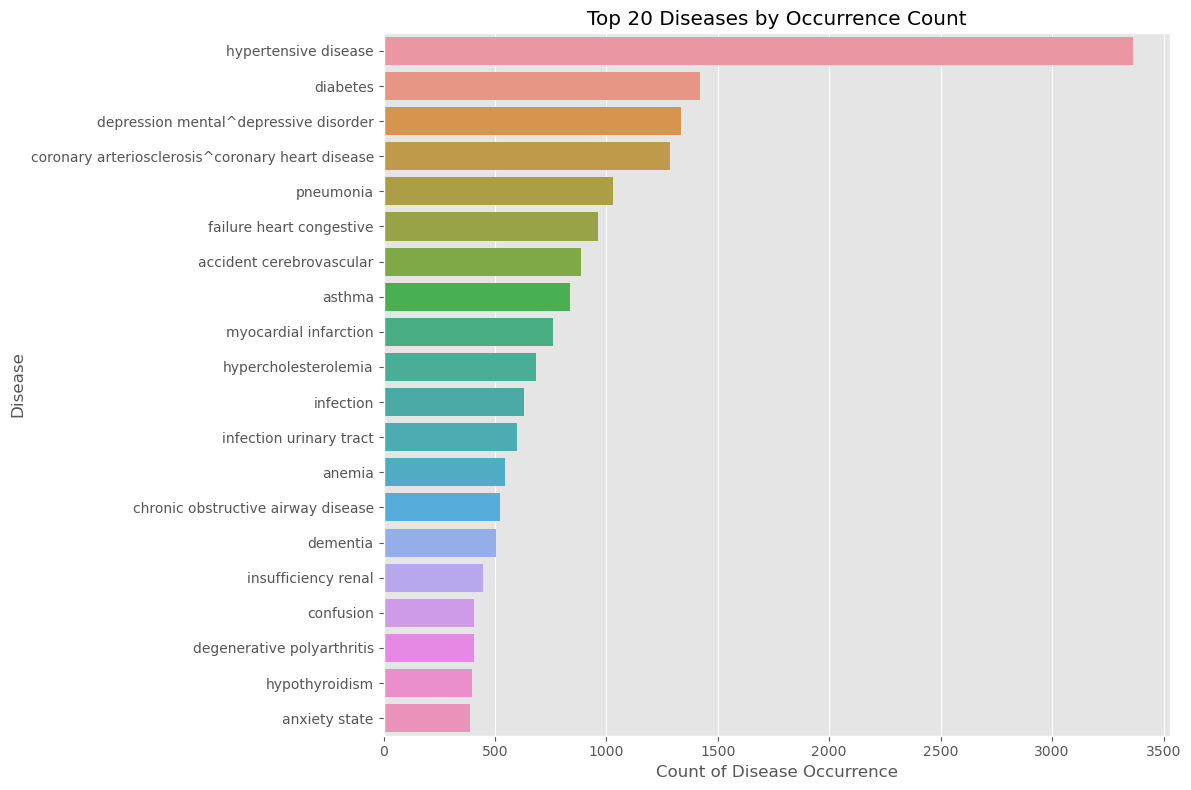

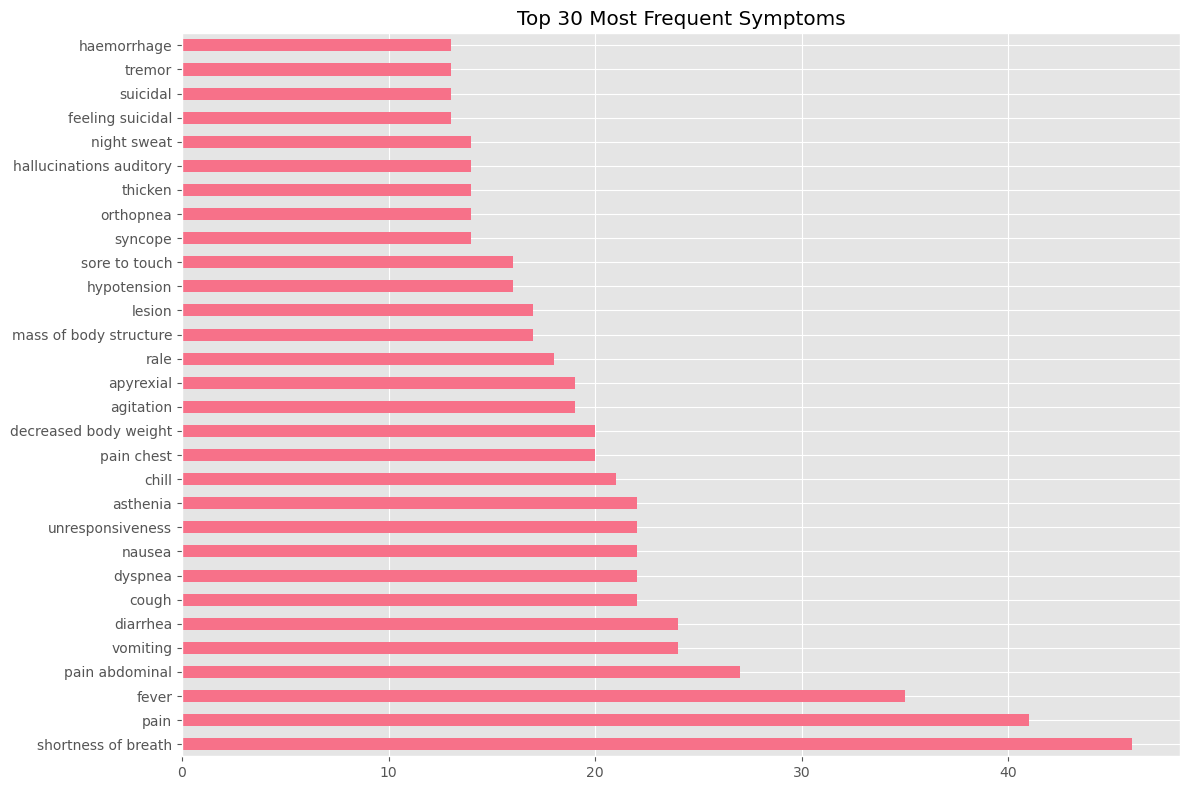

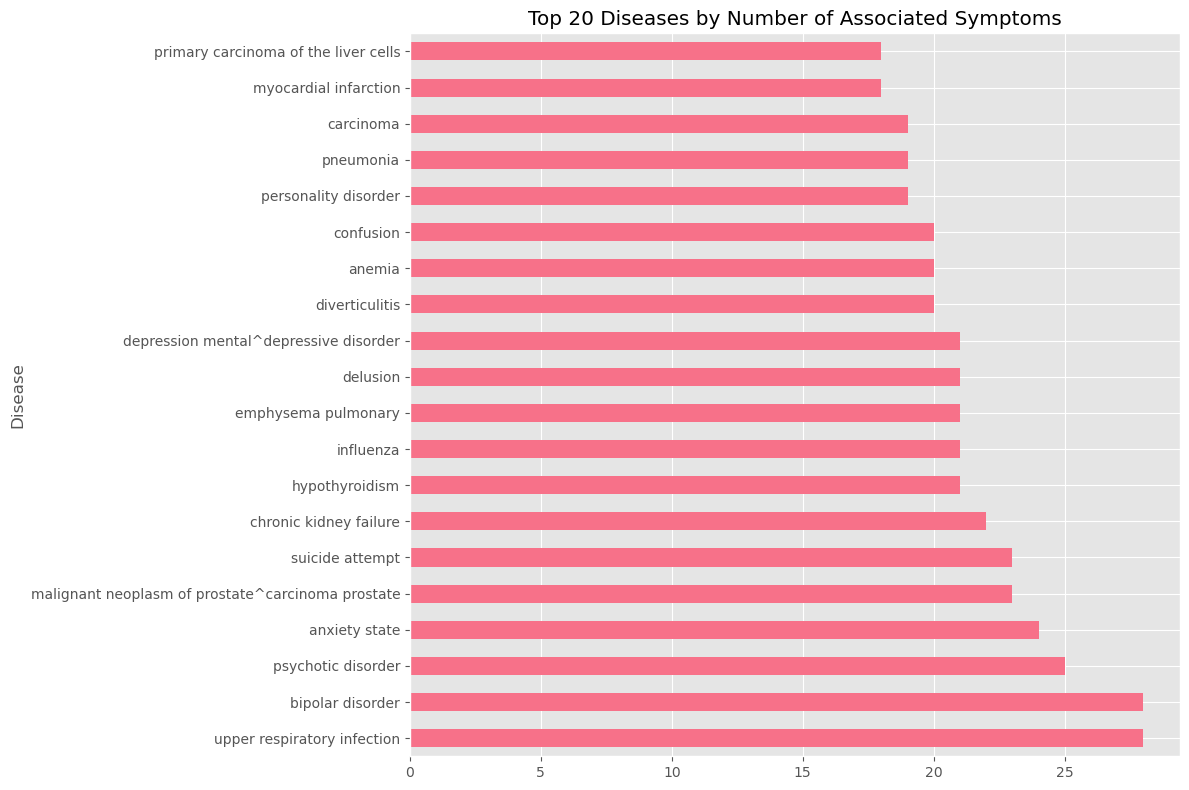

In [7]:
def perform_eda(df):
    """
    Perform exploratory data analysis on the cleaned dataset
    """
    # Disease distribution
    disease_counts = df[['Disease', 'Count of Disease Occurrence']].drop_duplicates()
    disease_counts = disease_counts.sort_values('Count of Disease Occurrence', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count of Disease Occurrence', y='Disease', data=disease_counts.head(20))
    plt.title('Top 20 Diseases by Occurrence Count')
    plt.tight_layout()
    plt.show()
    
    # Symptom frequency analysis
    all_symptoms = [symptom for sublist in df.groupby('Disease')['Symptom'].apply(list) 
                   for symptom in sublist]
    symptom_freq = pd.Series(all_symptoms).value_counts().head(30)
    
    plt.figure(figsize=(12, 8))
    symptom_freq.plot(kind='barh')
    plt.title('Top 30 Most Frequent Symptoms')
    plt.tight_layout()
    plt.show()
    
    # Symptoms per disease
    symptoms_per_disease = df.groupby('Disease')['Symptom'].count().sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    symptoms_per_disease.head(20).plot(kind='barh')
    plt.title('Top 20 Diseases by Number of Associated Symptoms')
    plt.tight_layout()
    plt.show()

perform_eda(cleaned_df)

In [8]:
!pip install wordcloud


In [9]:
import matplotlib.pyplot as plt
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [10]:
plt.style.use('seaborn-v0_8-whitegrid')  # for Seaborn >= 0.12


In [11]:
# Required installations (run these in a Jupyter cell or terminal if not installed):
# !pip install wordcloud seaborn networkx scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud
from collections import Counter
import numpy as np
from scipy.stats import zscore
from sklearn.metrics.pairwise import cosine_similarity

# Set Seaborn theme (recommended for modern versions)
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize': (12, 8)})

# %matplotlib inline  # Uncomment this if you're using a Jupyter Notebook

def advanced_eda(cleaned_df):
    """Enhanced EDA with medical insights"""

    # 1. Symptom Frequency Analysis (with Z-Score)
    all_symptoms = cleaned_df['Symptom'].tolist()
    symptom_counts = Counter(all_symptoms)

    symptom_stats = pd.DataFrame.from_dict(symptom_counts, orient='index', columns=['count'])
    symptom_stats['z_score'] = zscore(symptom_stats['count'])
    symptom_stats['pct_of_total'] = (symptom_stats['count'] / len(cleaned_df)) * 100

    significant_symptoms = symptom_stats[symptom_stats['z_score'] > 2.5].sort_values('count', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x=significant_symptoms['count'], y=significant_symptoms.index, palette='viridis')
    plt.title('Statistically Significant Symptoms (z-score > 2.5)')
    plt.xlabel('Occurrence Count')
    plt.ylabel('Symptom')
    plt.tight_layout()
    plt.show()

    # 2. Disease-Symptom Network Graph
    plt.figure(figsize=(16, 12))
    G = nx.from_pandas_edgelist(cleaned_df, 'Disease', 'Symptom')

    pos = nx.spring_layout(G, k=0.5, iterations=50)
    node_sizes = [len(list(G.neighbors(n))) * 50 for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.2, edge_color='gray')

    high_degree = {n for n, d in G.degree() if d > np.percentile([d for _, d in G.degree()], 90)}
    labels = {n: n if n in high_degree else '' for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')

    plt.title('Disease-Symptom Relationship Network', fontsize=16)
    plt.axis('off')
    plt.show()

    # 3. Symptom Co-occurrence Heatmap
    symptom_matrix = pd.crosstab(cleaned_df['Disease'], cleaned_df['Symptom'])
    co_occurrence = cosine_similarity(symptom_matrix.T)
    co_occurrence_df = pd.DataFrame(co_occurrence, index=symptom_matrix.columns, columns=symptom_matrix.columns)

    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(co_occurrence_df, dtype=bool))
    sns.heatmap(co_occurrence_df, mask=mask, cmap='coolwarm', center=0, annot=False, xticklabels=False, yticklabels=False)
    plt.title('Symptom Co-occurrence Patterns', fontsize=14)
    plt.show()

    # 4. Disease Symptom Word Clouds
    disease_groups = cleaned_df.groupby('Disease')['Symptom'].apply(list)

    for disease, symptoms in disease_groups.head(3).items():
        plt.figure(figsize=(10, 6))
        wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(symptoms))
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f'Key Symptoms for {disease}', fontsize=14)
        plt.axis('off')
        plt.show()

    # 5. Symptom Distribution by Disease Prevalence
    disease_counts = cleaned_df[['Disease', 'Count of Disease Occurrence']].drop_duplicates()
    disease_counts = disease_counts.sort_values('Count of Disease Occurrence', ascending=False)

    top_diseases = disease_counts.head(10)['Disease']
    symptom_dist = cleaned_df[cleaned_df['Disease'].isin(top_diseases)]

    plt.figure(figsize=(14, 8))
    sns.boxplot(data=symptom_dist, x='Count of Disease Occurrence', y='Disease', palette='mako', showfliers=False)
    plt.title('Symptom Distribution by Disease Prevalence', fontsize=14)
    plt.xlabel('Disease Occurrence Count (log scale)')
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

    # 6. Symptom Specificity Analysis (TF-IDF style)
    disease_freq = cleaned_df['Disease'].value_counts()
    symptom_freq = cleaned_df['Symptom'].value_counts()

    specificity = []
    for symptom, group in cleaned_df.groupby('Symptom'):
        idf = np.log(len(disease_freq) / len(group['Disease'].unique()))
        specificity.append((symptom, idf))

    specificity_df = pd.DataFrame(specificity, columns=['Symptom', 'Specificity']).sort_values('Specificity', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Specificity', y='Symptom', data=specificity_df.head(20), palette='rocket')
    plt.title('Top 20 Most Disease-Specific Symptoms', fontsize=14)
    plt.xlabel('Specificity Score (Higher = More Disease-Specific)')
    plt.tight_layout()
    plt.show()

    return {
        'symptom_stats': symptom_stats,
        'co_occurrence_matrix': co_occurrence_df,
        'specificity_scores': specificity_df
    }

# ✅ Example of how to run it:
# eda_results = advanced_eda(cleaned_df)


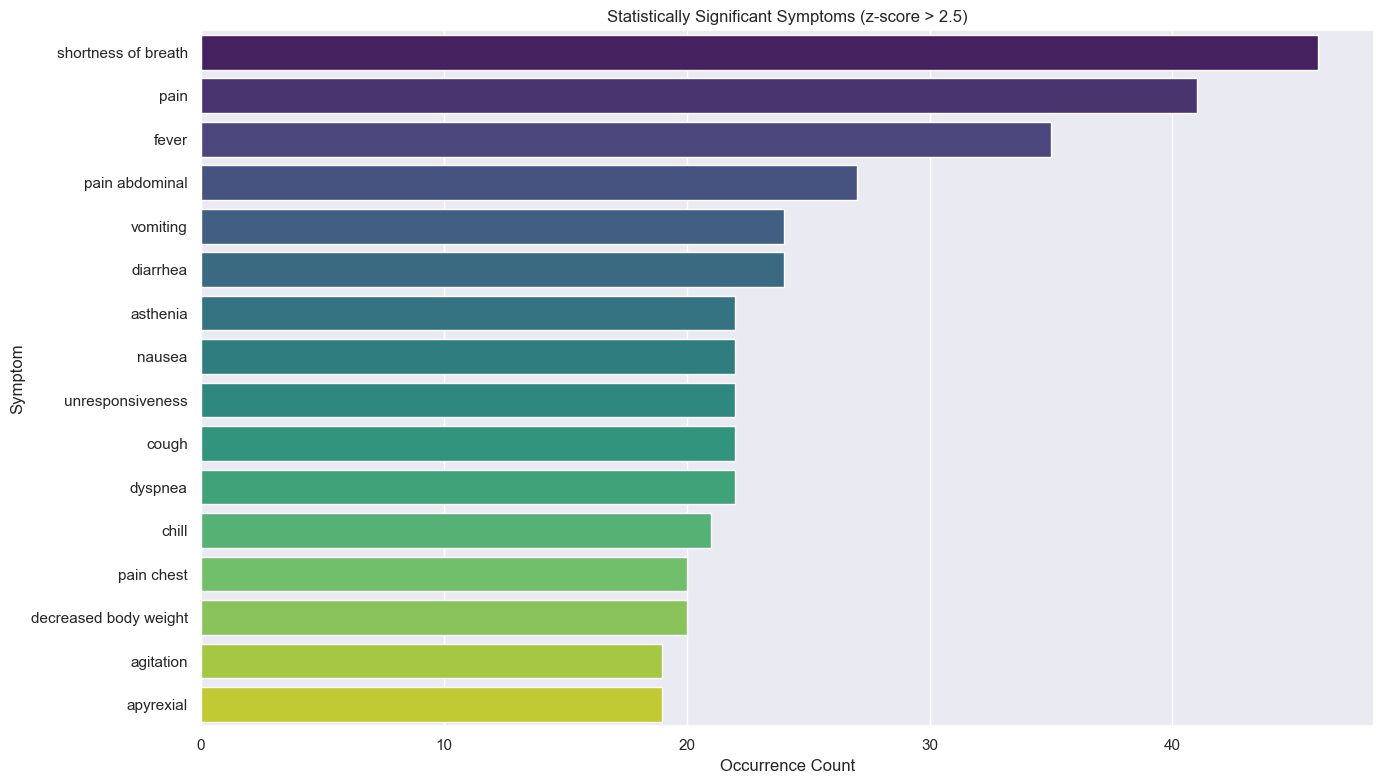

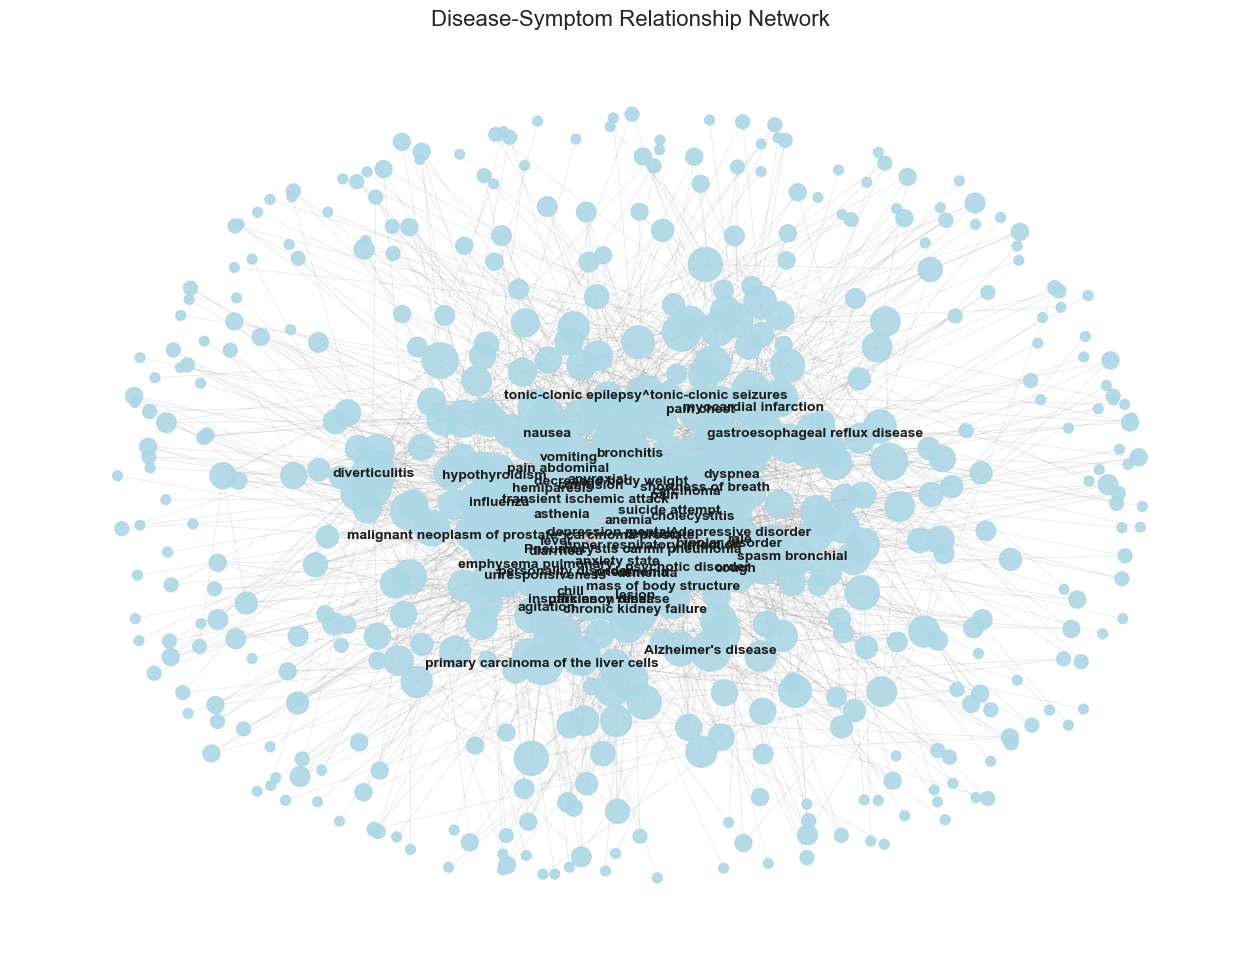

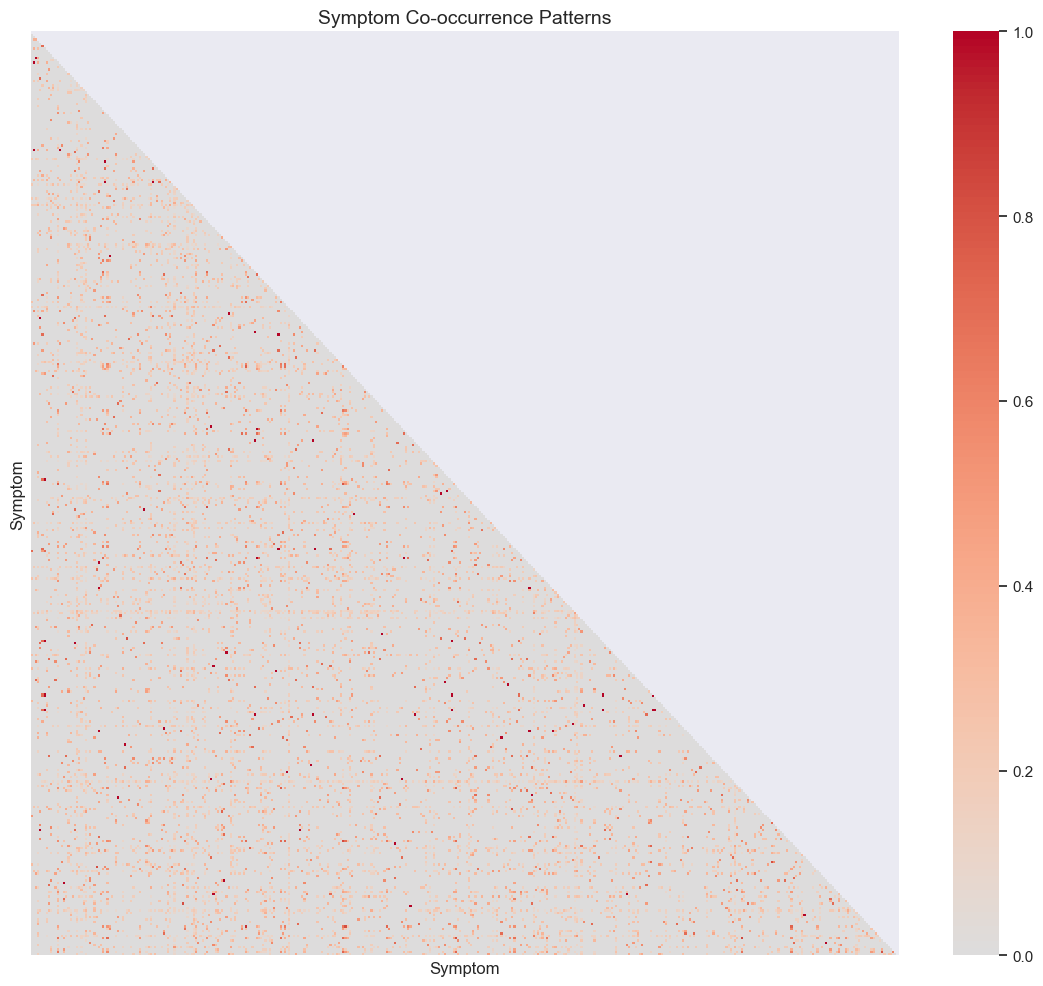

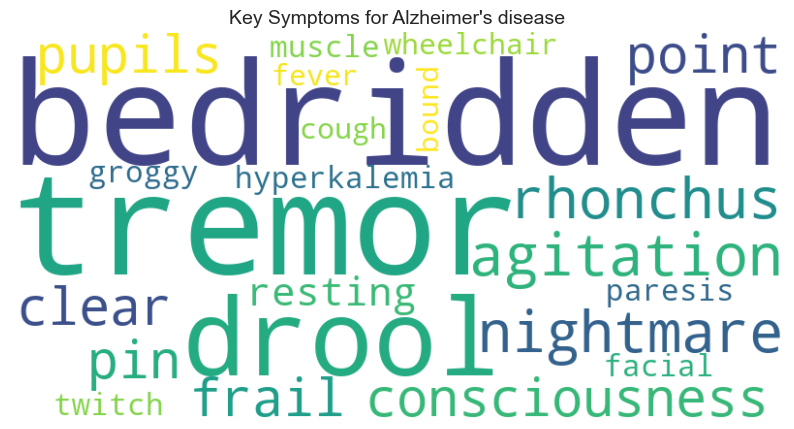

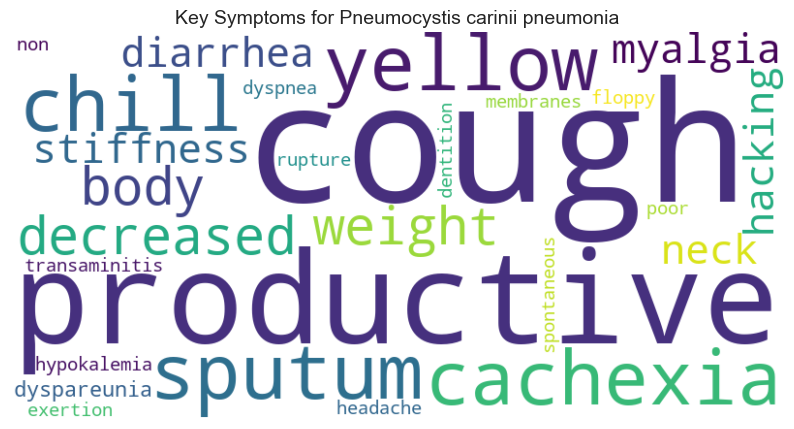

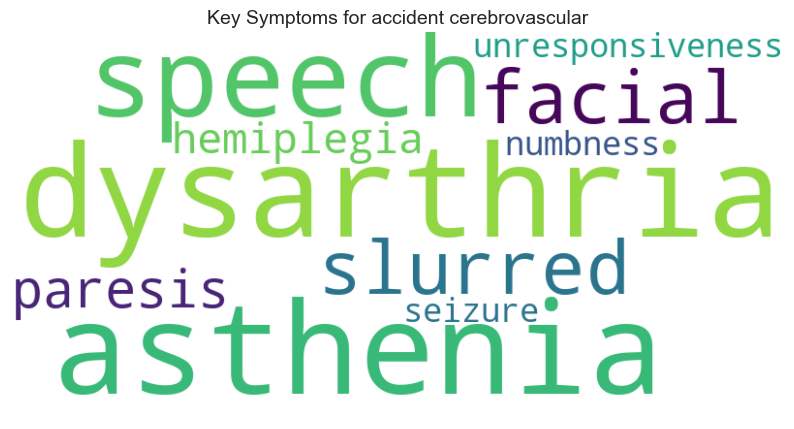

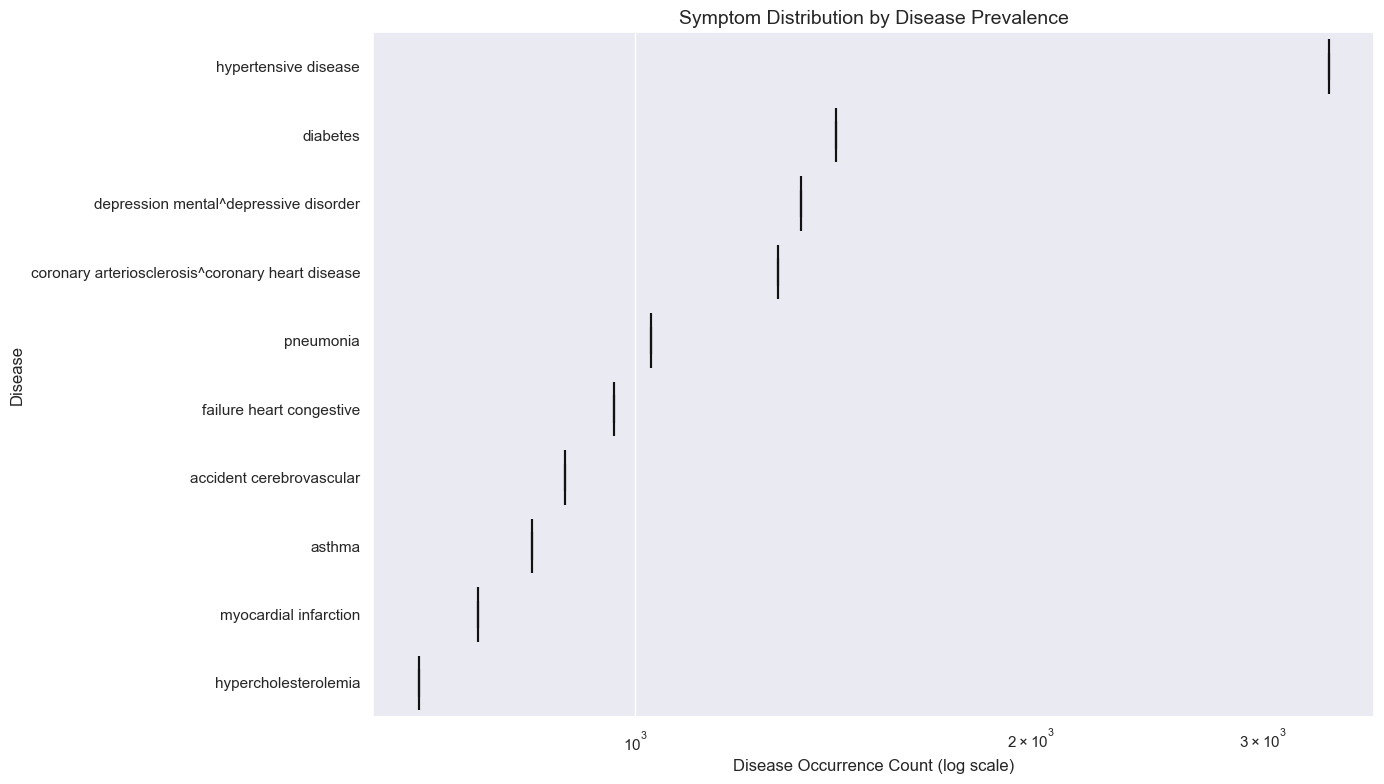

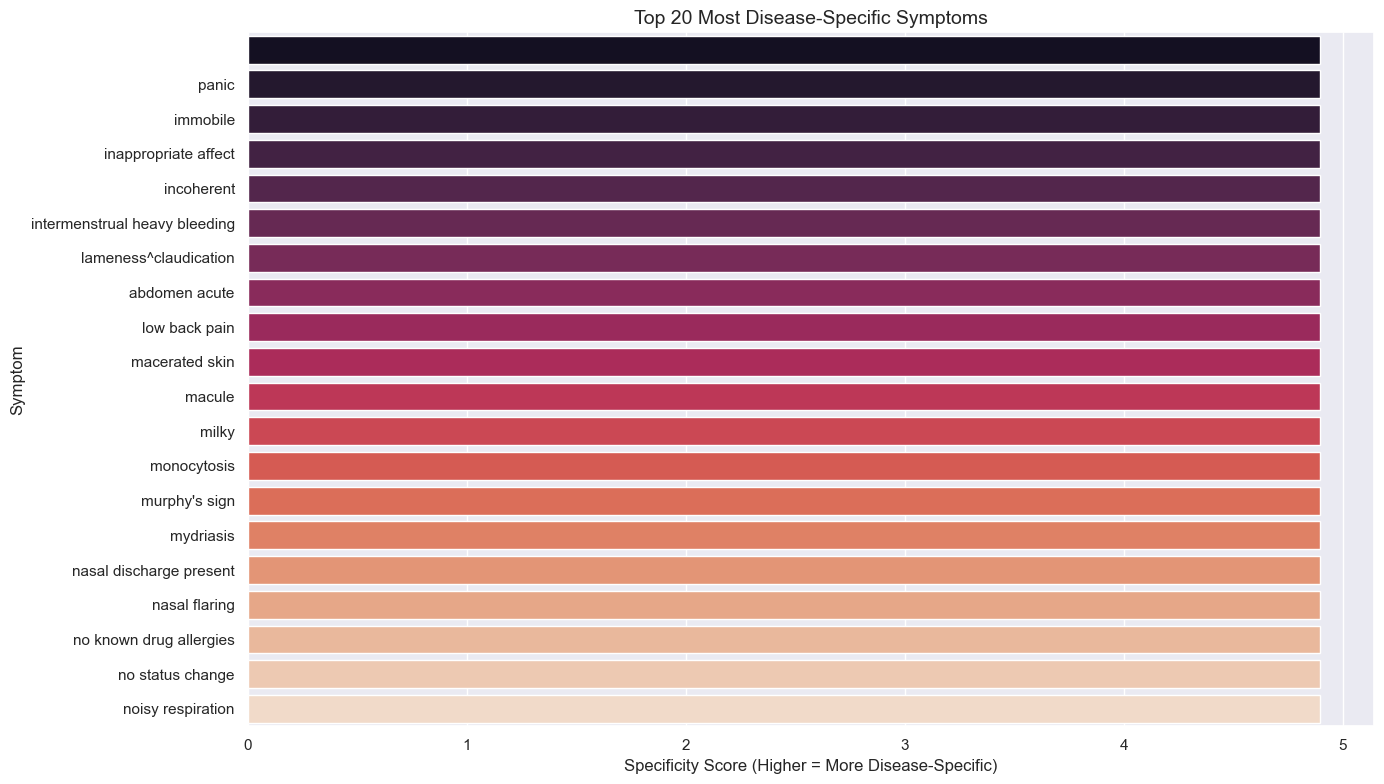

In [12]:
eda_results = advanced_eda(cleaned_df)

In [13]:
def prepare_features(df):
    """
    Prepare features for machine learning
    """
    # Group symptoms by disease
    disease_symptoms = df.groupby('Disease')['Symptom'].apply(list).reset_index()
    
    # Create binary symptom features
    mlb = MultiLabelBinarizer()
    symptom_features = pd.DataFrame(mlb.fit_transform(disease_symptoms['Symptom']),
                                columns=mlb.classes_,
                                index=disease_symptoms['Disease'])
    
    return disease_symptoms, symptom_features

disease_symptoms, symptom_features = prepare_features(cleaned_df)

# Display feature matrix
print("Symptom feature matrix shape:", symptom_features.shape)
display(symptom_features.head())

Symptom feature matrix shape: (134, 401)


,,abdomen acute,abdominal bloating,abdominal tenderness,abnormal sensation,abnormally hard consistency,abortion,abscess bacterial,absences finding,achalasia,ache,adverse reaction^adverse effect,agitation,air fluid level,alcohol binge episode,alcoholic withdrawal symptoms,ambidexterity,angina pectoris,anorexia,anosmia,aphagia,apyrexial,arthralgia,ascites,asterixis,asthenia,asymptomatic,ataxia,atypia,aura,awakening early,barking cough,bedridden^bedridden,behavior hyperactive,behavior showing increased motor activity,blackout,blanch,bleeding of vagina,bowel sounds decreased,bradycardia,bradykinesia,breakthrough pain,breath sounds decreased,breath-holding spell,breech presentation,bruit,burning sensation,cachexia,cardiomegaly,cardiovascular finding^cardiovascular event,catatonia,catching breath,charleyhorse,chest discomfort,chest tightness,chill,choke,cicatrisation,cicatrisation^scar tissue,clammy skin,clonus,clumsiness,colic abdominal,consciousness clear,constipation,coordination abnormal,cough,cushingoid facies^cushingoid habitus,cyanosis,cystic lesion,debilitation,decompensation,decreased body weight,decreased stool caliber,decreased translucency,diarrhea,difficulty,difficulty passing urine,disequilibrium,distended abdomen,distress respiratory,disturbed family,dizziness,dizzy spells,drool,drowsiness,drowsiness^sleepy,dullness,dysarthria,dysdiadochokinesia,dysesthesia,dyspareunia,dyspnea,dyspnea on exertion,dysuria,ecchymosis,egophony,elation,emphysematous change,energy increased,enuresis,erythema,estrogen use,excruciating pain,exhaustion,extrapyramidal sign,extreme exhaustion,facial paresis,fall,fatigability,fatigue,fatigue^tired,fear of falling,fecaluria,feces in rectum,feeling hopeless,feeling strange,feeling suicidal,feels hot/feverish,fever,flare,flatulence,floppy,flushing,focal seizures,food intolerance,formication,frail,fremitus,frothy sputum,gag,gasping for breath,general discomfort,general unsteadiness,giddy mood,gravida 0,gravida 10,green sputum,groggy,guaiac positive,gurgle,hacking cough,haemoptysis,haemorrhage,hallucinations auditory,hallucinations visual,has religious belief,headache,heartburn,heavy feeling,heavy legs,heberden's node,hematochezia,hematocrit decreased,hematuria,heme positive,hemianopsia homonymous,hemiplegia,hemodynamically stable,hepatomegaly,hepatosplenomegaly,hirsutism,hoard,hoarseness,homelessness,homicidal thoughts,hot flush,hunger,hydropneumothorax,hyperacusis,hypercapnia,hyperemesis,hyperhidrosis disorder,hyperkalemia,hypersomnia,hypersomnolence,hypertonicity,hyperventilation,hypesthesia,hypoalbuminemia,hypocalcemia result,hypokalemia,hypokinesia,hypometabolism,hyponatremia,hypoproteinemia,hypotension,"hypothermia, natural",hypoxemia,immobile,impaired cognition,inappropriate affect,incoherent,indifferent mood,intermenstrual heavy bleeding,intoxication,irritable mood,jugular venous distention,labored breathing,lameness^claudication,large-for-dates fetus,left atrial hypertrophy,lesion,lethargy,lightheadedness,lip smacking,loose associations,low back pain,lung nodule,macerated skin,macule,malaise,mass in breast,mass of body structure,mediastinal shift,mental status changes,metastatic lesion,milky,moan,monoclonal,monocytosis,mood depressed,moody,motor retardation,murphy's sign,muscle hypotonia^hypotonic,muscle twitch,myalgia,mydriasis,myoclonus,nasal discharge present,nasal flaring,nausea,nausea and vomiting,neck stiffness,neologism,nervousness,night sweat,nightmare,no known drug allergies,no status change,noisy respiration,non-productive cough,nonsmoker,numbness,numbness of hand,oliguria,orthopnea,orthostasis,out of breath,overweight,pain,pain abdominal,pain back,pain chest,pain foot,pain in lower limb,pain neck,painful swallowing,pallor,palpitation,panic,pansystolic murmur,para 1,para 2,paralyse,paraparesis,paresis,paresthesia,passed stones,patient non compliance,pericardial friction rub,phonophobia,photophobia,photopsia,pin-point pupils,pleuritic pain,pneumatouria,polydypsia,polymyalgia,polyuri

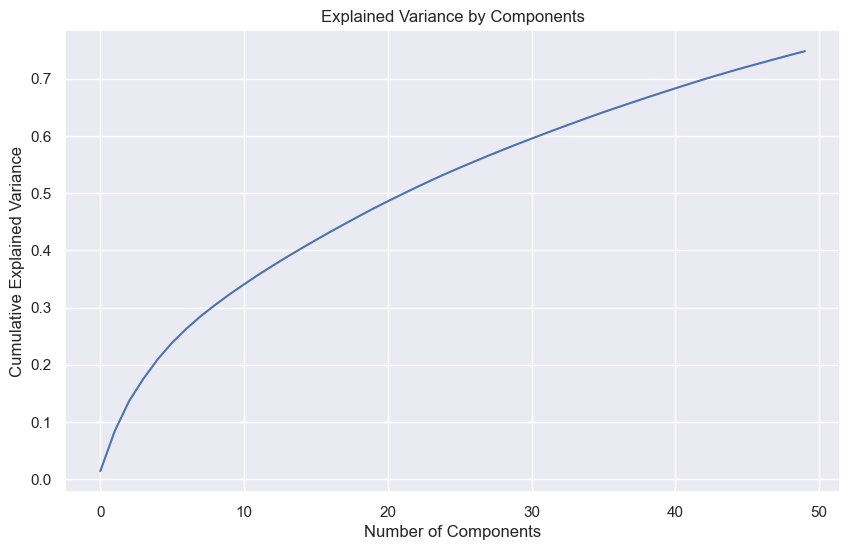

In [14]:
def reduce_dimensionality(features, n_components=50):
    """
    Reduce feature dimensionality using Truncated SVD
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_features = svd.fit_transform(features)
    
    # Plot explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(svd.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Components')
    plt.grid(True)
    plt.show()
    
    return reduced_features

reduced_features = reduce_dimensionality(symptom_features)

In [15]:
df = pd.read_excel(r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx')  # Replace with your actual file path

# Print the actual column names
print("Available columns:", df.columns)

Available columns: Index(['Disease', 'Count of Disease Occurrence', 'Symptom'], dtype='object')


In [16]:
df = load_and_clean(r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx')
print(f"Data after cleaning: {df.shape}")
print(df.head())


Data after cleaning: (1866, 3)
                Disease  Count of Disease Occurrence              Symptom
0  hypertensive disease                       3363.0           pain chest
1  hypertensive disease                       3363.0  shortness of breath
2  hypertensive disease                       3363.0            dizziness
3  hypertensive disease                       3363.0             asthenia
4  hypertensive disease                       3363.0                 fall


In [17]:
df = df.dropna(subset=['Symptom', 'Disease'])


In [18]:
def load_and_clean(filepath):
    df = pd.read_excel(filepath)

    # Rename columns if needed (optional, based on your real file)
    df.columns = [col.strip().lower() for col in df.columns]
    if 'count of disease occurrence' in df.columns:
        df = df.drop(columns=['count of disease occurrence'])

    # Ensure the required columns are present
    if not {'symptom', 'disease'}.issubset(df.columns):
        raise ValueError("The required columns 'symptom' and 'disease' are missing.")

    # Drop rows with missing values
    df = df.dropna(subset=['symptom', 'disease'])

    # Clean strings
    df['symptom'] = df['symptom'].astype(str).str.strip().str.lower()
    df['disease'] = df['disease'].astype(str).str.strip().str.lower()

    # Remove diseases with fewer than 2 occurrences
    disease_counts = df['disease'].value_counts()
    df = df[df['disease'].isin(disease_counts[disease_counts >= 2].index)]

    print(f"Data after cleaning: {df.shape}")
    return df


In [19]:
df = load_and_clean(r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx')
print(f"Data after cleaning: {df.shape}")
print(df.head())


Data after cleaning: (0, 2)
Data after cleaning: (0, 2)
Empty DataFrame
Columns: [disease, symptom]
Index: []


Loading and cleaning data...
Loaded 1865 records
Preparing data...
Number of samples: 1865, Number of features (symptoms): 401
Number of unique diseases (classes): 134
Train size: 1305, Test size: 560

Training SVM model...
SVM accuracy: 0.0054, Training time: 23.53s

Training Naive Bayes model...
Naive Bayes accuracy: 0.0036, Training time: 0.15s

Training Random Forest model...
Random Forest accuracy: 0.0036, Training time: 1.00s

Model Comparison:
           Model  Accuracy  Training Time (s)
0            SVM  0.005357          23.534025
1    Naive Bayes  0.003571           0.152659
2  Random Forest  0.003571           0.998456


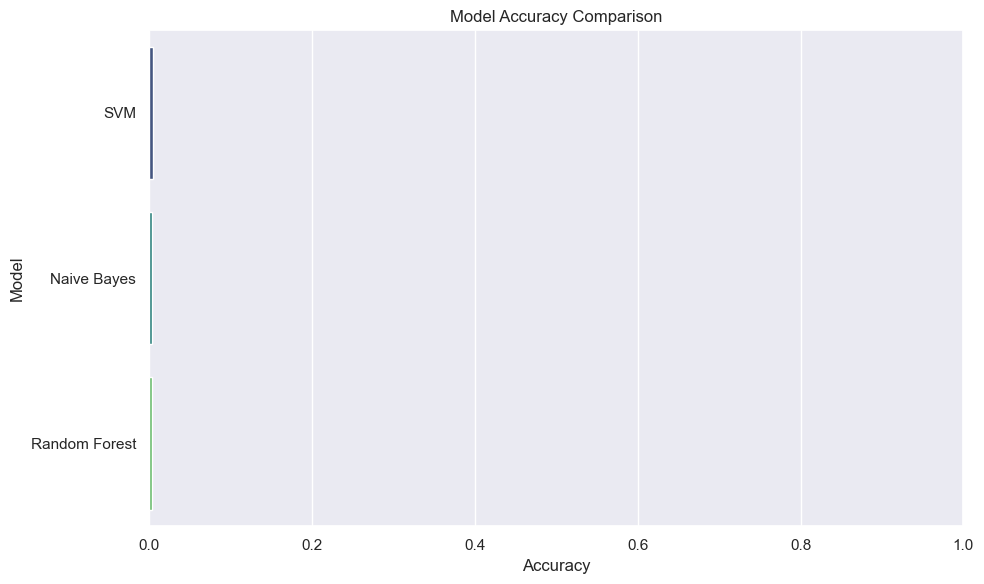


Best model: SVM


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time

def load_and_clean(filepath):
    """Load and clean the dataset."""
    try:
        df = pd.read_excel(filepath)
        
        # Forward fill disease names and drop rows with missing symptoms
        df['Disease'] = df['Disease'].ffill()
        df = df.dropna(subset=['Symptom'])
        
        # Clean text data
        df['Symptom'] = df['Symptom'].str.strip().str.lower()
        df['Disease'] = df['Disease'].str.strip().str.lower()
        
        # Remove diseases with fewer than 2 occurrences (to keep classes with ≥2 samples)
        disease_counts = df['Disease'].value_counts()
        valid_diseases = disease_counts[disease_counts >= 2].index
        df = df[df['Disease'].isin(valid_diseases)]
        
        return df.reset_index(drop=True)
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def prepare_data(cleaned_df):
    """Prepare features and target without grouping by disease."""
    try:
        # Each row is one sample with one symptom
        # Convert symptoms into binary features using MultiLabelBinarizer
        # Since each row has one symptom, wrap it in a list for MultiLabelBinarizer
        mlb = MultiLabelBinarizer()
        X = pd.DataFrame(mlb.fit_transform(cleaned_df['Symptom'].apply(lambda x: [x])),
                         columns=mlb.classes_)
        
        y = cleaned_df['Disease']
        
        print(f"Number of samples: {len(X)}, Number of features (symptoms): {X.shape[1]}")
        print(f"Number of unique diseases (classes): {y.nunique()}")
        
        return X, y, mlb
    except Exception as e:
        print(f"Error preparing data: {e}")
        raise

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    return acc, report

if __name__ == "__main__":
    try:
        # Step 1: Load and clean data
        print("Loading and cleaning data...")
        df = load_and_clean(r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx')
        print(f"Loaded {len(df)} records")
        
        # Step 2: Prepare data
        print("Preparing data...")
        X, y, mlb = prepare_data(df)
        
        # Step 3: Split dataset without stratify (to avoid error)
        if len(X) == 0:
            raise ValueError("No data available for training after preprocessing")
            
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, 
            test_size=0.3, 
            random_state=42
        )
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        
        # Step 4: Initialize models
        svm_model = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
        nb_model = MultinomialNB()
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Step 5: Train models with timing
        models = {
            'SVM': svm_model,
            'Naive Bayes': nb_model,
            'Random Forest': rf_model
        }
        
        results = []
        for name, model in models.items():
            print(f"\nTraining {name} model...")
            start_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - start_time
            
            # Evaluate
            acc, report = evaluate_model(model, X_test, y_test)
            results.append({
                'Model': name,
                'Accuracy': acc,
                'Training Time (s)': train_time,
                'Report': report,
                'ModelObj': model
            })
            print(f"{name} accuracy: {acc:.4f}, Training time: {train_time:.2f}s")
        
        # Step 6: Report results
        results_df = pd.DataFrame(results)
        print("\nModel Comparison:")
        print(results_df[['Model', 'Accuracy', 'Training Time (s)']])
        
        # Step 7: Visualize
        plt.figure(figsize=(10, 6))
        sns.barplot(data=results_df, x='Accuracy', y='Model', palette='viridis')
        plt.title('Model Accuracy Comparison')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()
        
        # Save the best model
        best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'ModelObj']
        print(f"\nBest model: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}")
        
    except Exception as e:
        print(f"Error in main execution: {e}")


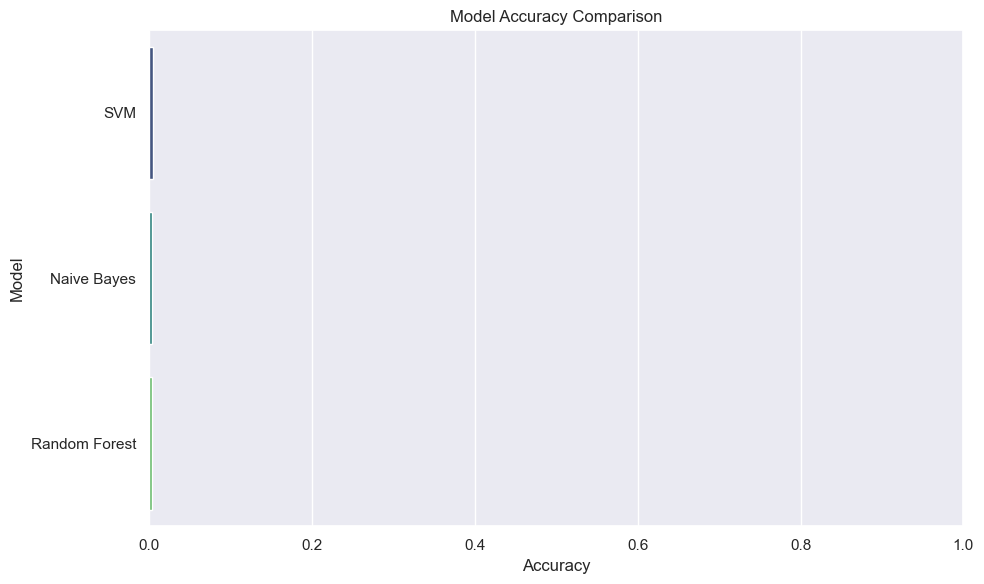

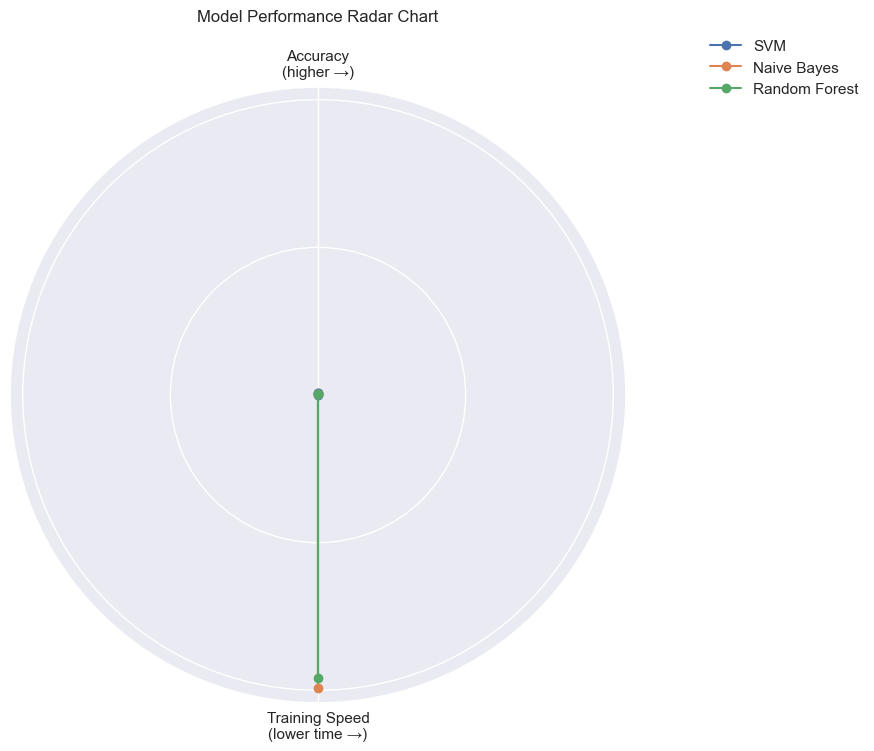

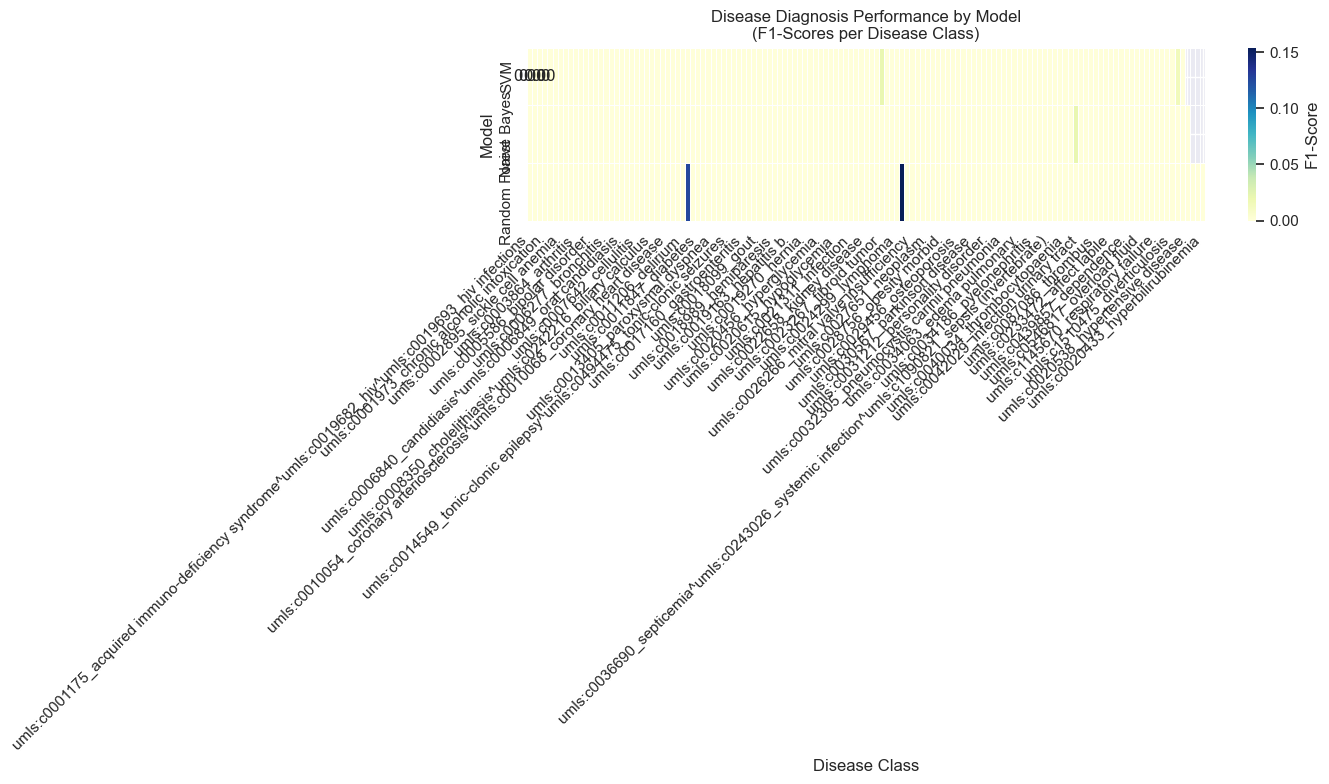


Best model: SVM


In [21]:
# ... [Keep all previous imports and functions unchanged] ...

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    return acc, report

def plot_radar_chart(results_df):
    """Create a radar chart comparing accuracy and training time."""
    categories = ['Accuracy', 'Training Time (s)']
    N = len(categories)

    # Normalize training time to [0,1] scale (inverted: lower time = better)
    max_time = results_df['Training Time (s)'].max()
    results_df['Norm Training Time'] = results_df['Training Time (s)'] / max_time

    # Prepare data for radar chart
    values = []
    labels = results_df['Model'].tolist()
    for _, row in results_df.iterrows():
        values.append([row['Accuracy'], 1 - row['Norm Training Time']])  # Invert time for better=outer
    
    values = np.array(values)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)  # Start at top
    
    for i, label in enumerate(labels):
        vals = values[i].tolist()
        vals += vals[:1]  # Close the loop
        ax.plot(angles, vals, label=label, marker='o')
        ax.fill(angles, vals, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['Accuracy\n(higher →)', 'Training Speed\n(lower time →)'])
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels([])  # Remove radial labels for clarity
    ax.set_title('Model Performance Radar Chart', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.show()

def plot_classification_heatmap(results, X_test, y_test):
    """Create a heatmap of F1-scores per disease class."""
    plt.figure(figsize=(14, 8))
    
    # Prepare data
    heatmap_data = []
    model_names = []
    for res in results:
        model = res['ModelObj']
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        
        # Extract F1-scores for individual classes
        class_scores = {k: v['f1-score'] for k, v in report.items() 
                       if k not in ['accuracy', 'macro avg', 'weighted avg']}
        heatmap_data.append(pd.Series(class_scores))
        model_names.append(res['Model'])
    
    df_heatmap = pd.concat(heatmap_data, axis=1)
    df_heatmap.columns = model_names

    # Plot
    sns.heatmap(df_heatmap.T, annot=True, fmt=".2f", cmap="YlGnBu", 
                cbar_kws={'label': 'F1-Score'}, linewidths=0.5)
    plt.title('Disease Diagnosis Performance by Model\n(F1-Scores per Disease Class)')
    plt.xlabel('Disease Class')
    plt.ylabel('Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        # ... [Keep all previous steps unchanged until visualization] ...

        # Step 7: Visualize
        # Original accuracy bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=results_df, x='Accuracy', y='Model', palette='viridis')
        plt.title('Model Accuracy Comparison')
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

        # New: Radar chart comparison
        plot_radar_chart(results_df)

        # New: Heatmap of class-level performance
        plot_classification_heatmap(results, X_test, y_test)

        # Save the best model (unchanged)
        best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'ModelObj']
        print(f"\nBest model: {results_df.loc[results_df['Accuracy'].idxmax(), 'Model']}")
        
    except Exception as e:
        print(f"Error in main execution: {e}")


In [22]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # Assuming you're using an SVM model for classification

# Initialize and train the TF-IDF Vectorizer on some training data (make sure to use the same training data)
corpus = ["fever cough", "headache dizziness", "chest pain shortness of breath", "fatigue cough", "nausea vomiting"]
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(corpus)

# Example SVM model (replace with your trained model)
svm_model = SVC(probability=True)
svm_model.fit(X_tfidf, ["disease1", "disease2", "disease3", "disease4", "disease5"])

def predict_disease(symptoms_text, model, threshold=0.5):
    # Transform the input symptoms using the pre-trained tfidf
    symptoms_tfidf = tfidf.transform([symptoms_text])
    
    # Get prediction probabilities
    probas = model.predict_proba(symptoms_tfidf)
    
    # Get top predictions
    top_n = 3
    top_indices = np.argsort(probas, axis=1)[:, -top_n:][0][::-1]
    top_classes = model.classes_[top_indices]
    top_probas = probas[0, top_indices]
    
    # Filter predictions above threshold
    results = []
    for disease, proba in zip(top_classes, top_probas):
        if proba >= threshold:
            results.append({'Disease': disease, 'Probability': round(proba, 2)})
    
    return results if results else "No confident prediction (all probabilities below threshold)"

# Example prediction
example_symptoms = "pain chest shortness of breath dizziness"
best_model = svm_model  # Assuming svm_model is the model you want to use
prediction = predict_disease(example_symptoms, best_model)
print("\nExample Prediction:")
print(prediction)




Example Prediction:
No confident prediction (all probabilities below threshold)


In [23]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Step 1: Load your Excel dataset
df = pd.read_excel(r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx')  # make sure this file is in the same folder

# Step 2: Prepare training data
# Assume your Excel file has columns like: 'Symptoms' and 'Disease'
symptoms = df['Symptom'].astype(str).tolist()  # Convert symptoms to string if not already
diseases = df['Disease'].tolist()

# Step 3: Train vectorizer and model
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(symptoms)
model = SVC(probability=True)
model.fit(X_train, diseases)

# Step 4: Prediction function
def predict_disease(user_symptoms_list):
    if len(user_symptoms_list) > 10:
        print("Please enter up to 10 symptoms only.")
        return
    symptom_text = " ".join(user_symptoms_list)
    X_input = vectorizer.transform([symptom_text])
    probs = model.predict_proba(X_input)[0]
    top_indices = np.argsort(probs)[-3:][::-1]
    print("\nTop 3 Predicted Diseases:")
    for idx in top_indices:
        print(f"{model.classes_[idx]}: {round(probs[idx]*100, 2)}%")

# Step 5: Take user input
user_input = input("Enter up to 10 symptoms (comma-separated): ")
user_symptoms = [sym.strip() for sym in user_input.split(",") if sym.strip()]
predict_disease(user_symptoms)


Enter up to 10 symptoms (comma-separated):  cough,fever,anxiety



Top 3 Predicted Diseases:
nan: 88.64%
UMLS:C0021400_influenza: 0.08%
UMLS:C0085584_encephalopathy: 0.08%


In [24]:
import pandas as pd
import re

# 1. Load the Excel file
df = pd.read_excel(r'C:\Users\sanjo\Desktop\uncleaneddataset.xlsx', sheet_name='training_data_original')

# 2. Forward-fill Disease names
df['Disease'] = df['Disease'].ffill()

# 3. Drop rows with missing symptoms
df = df.dropna(subset=['Symptom'])

# 4. Function to split and clean UMLS codes
def clean_umls(text):
    # Remove UMLS code and underscore, keep only the name after '_'
    return re.sub(r'^UMLS:[^_]*_', '', str(text))

def split_and_clean(row):
    # Split diseases and symptoms by ^, then clean UMLS codes
    diseases = [clean_umls(d) for d in str(row['Disease']).split('^')]
    symptoms = [clean_umls(s) for s in str(row['Symptom']).split('^')]
    # Create all disease-symptom pairs
    return pd.DataFrame({'Disease': diseases * len(symptoms),
                         'Symptom': symptoms * len(diseases)})

# 5. Build the clean dataset
clean_rows = []
for _, row in df.iterrows():
    diseases = [clean_umls(d) for d in str(row['Disease']).split('^')]
    symptoms = [clean_umls(s) for s in str(row['Symptom']).split('^')]
    for disease in diseases:
        for symptom in symptoms:
            clean_rows.append({'Disease': disease.strip().lower(),
                               'Symptom': symptom.strip().lower()})

clean_df = pd.DataFrame(clean_rows)

# 6. Remove empty or null entries and duplicates
clean_df = clean_df.replace('', pd.NA).dropna()
clean_df = clean_df.drop_duplicates()

# 7. Save to Excel
clean_df.to_excel('cleaneddataset.xlsx', index=False)

print(f"Cleaned data saved to 'cleaneddataset.xlsx' with {len(clean_df)} rows.")


Cleaned data saved to 'cleaneddataset.xlsx' with 2113 rows.


In [25]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Sample training data
symptoms = [
    "angina pectoris asthenia dizziness fall nausea pain chest palpitation pressure chest shortness of breath sweat sweating increased syncope vertigo",
    "asthenia labored breathing mental status changes nausea orthopnea pain chest polydypsia polyuria rale shortness of breath sweat sweating increased unresponsiveness vertigo vomiting",
    "agitation blackout difficulty energy increased feeling hopeless feeling suicidal hallucinations auditory hallucinations visual homelessness intoxication irritable mood mood depressed motor retardation nightmare sleeplessness suicidal tremor unable to concentrate verbal auditory hallucinations weepiness worry",
    "agitation blackout difficulty energy increased feeling hopeless feeling suicidal hallucinations auditory hallucinations visual homelessness intoxication irritable mood mood depressed motor retardation nightmare sleeplessness suicidal tremor unable to concentrate verbal auditory hallucinations weepiness worry",
    "angina pectoris chest tightness dyspnea on exertion hypokinesia orthopnea pain chest pressure chest shortness of breath sweat sweating increased",
    "angina pectoris chest tightness dyspnea on exertion hypokinesia orthopnea pain chest pressure chest shortness of breath sweat sweating increased",
    "breath sounds decreased chill cough decreased translucency distress respiratory fever green sputum haemoptysis malaise night sweat non-productive cough pleuritic pain productive cough rale rhonchus shortness of breath tachypnea wheezing yellow sputum",
    "cough dyspnea jugular venous distention orthopnea rale shortness of breath wheezing",
    "asthenia dysarthria facial paresis hemiplegia numbness seizure speech slurred unresponsiveness",
    "chest tightness cough distress respiratory non-productive cough pleuritic pain productive cough shortness of breath symptom aggravating factors wheezing",
    "angina pectoris bradycardia chest discomfort chest tightness dyspnea hypokinesia orthopnea pain chest palpitation presence of q wave pressure chest rale shortness of breath st segment depression st segment elevation sweat sweating increased syncope t wave inverted",
    "bradycardia chest discomfort dyspnea nonsmoker numbness pain pain chest pressure chest shortness of breath st segment depression sweat sweating increased syncope t wave inverted worry",
    "abscess bacterial apyrexial chill cough decreased translucency diarrhea erythema fever hepatosplenomegaly pain pruritus swelling",
    "asthenia consciousness clear difficulty passing urine distress respiratory dysuria fever hematuria hemodynamically stable hyponatremia lethargy mental status changes renal angle tenderness",
    "arthralgia asthenia chill dizziness ecchymosis fatigue guaiac positive haemorrhage heme positive hyponatremia monoclonal orthostasis pain pain back pallor rhonchus shortness of breath swelling transaminitis tumor cell invasion",
    "chest tightness cough distress respiratory dyspnea hypercapnia hypoxemia patient non compliance shortness of breath sputum purulent wheezing",
    "abdominal tenderness agitation bedridden cough ecchymosis facial paresis fall fever hallucinations auditory lethargy pain rale rhonchus syncope unconscious state unresponsiveness unsteady gait",
    "apyrexial ascites asthenia breath sounds decreased diarrhea difficulty dyspnea guaiac positive hyperkalemia hypokinesia hypotension mental status changes orthopnea rale shortness of breath swelling urgency of micturition",
    "agitation asterixis asthenia consciousness clear dizziness dysarthria enuresis fall headache hyponatremia lethargy lightheadedness mental status changes muscle twitch seizure sleepy speech slurred tremor unconscious state unresponsiveness",
    "asthenia drowsiness food intolerance general discomfort non-productive cough nonsmoker numbness of hand pain polydypsia stiffness unsteady gait",
    "agitation asthenia difficulty drowsiness fall fatigue hyponatremia hypotension mass of body structure mental status changes motor retardation nightmare numbness polyuria prostatism shortness of breath sleepy speech slurred syncope tired unsteady gait vomiting weight gain",
    "agitation blackout consciousness clear difficulty feeling hopeless feeling suicidal formication hallucinations auditory hallucinations visual has religious belief hot flush irritable mood mood depressed nervousness nightmare pain pain chest palpitation patient non compliance sleeplessness suicidal tremor weepiness worry",
    "ascites cushingoid facies cushingoid habitus decreased body weight emphysematous change hematuria hoarseness lesion mass of body structure pain thicken",
    "ascites cushingoid facies cushingoid habitus decreased body weight emphysematous change hematuria hoarseness lesion mass of body structure pain thicken",
    "chill cough decreased body weight diarrhea feeling suicidal fever hypotonic muscle hypotonia night sweat patient non compliance pleuritic pain productive cough spontaneous rupture of membranes tachypnea",
    "chill cough decreased body weight diarrhea feeling suicidal fever hypotonic muscle hypotonia night sweat patient non compliance pleuritic pain productive cough spontaneous rupture of membranes tachypnea",
    "chill cough decreased body weight diarrhea feeling suicidal fever hypotonic muscle hypotonia night sweat patient non compliance pleuritic pain productive cough spontaneous rupture of membranes tachypnea",
    "abscess bacterial chill erythema fever hyperacusis hypesthesia pain pain chest patient non compliance pruritus redness scratch marks sore to touch swelling",
    "asthenia burning sensation chest tightness constipation general discomfort heartburn hyponatremia nausea pain pain abdominal pain chest palpitation presence of q wave satiety early sensory discomfort sweat sweating increased throbbing sensation quality",
    "apyrexial bradycardia breech presentation chill cyanosis distress respiratory fever haemorrhage hypotension lethargy rale spontaneous rupture of membranes tachypnea unresponsiveness",
    "apyrexial bradycardia breech presentation chill cyanosis distress respiratory fever haemorrhage hypotension lethargy rale spontaneous rupture of membranes tachypnea unresponsiveness",
    "apyrexial bradycardia breech presentation chill cyanosis distress respiratory fever haemorrhage hypotension lethargy rale spontaneous rupture of membranes tachypnea unresponsiveness",
    "cardiomegaly clonus ecchymosis erythema hypotension non-productive cough pain pain in lower limb rale redness shortness of breath swelling",
    "anorexia asthenia blackout diarrhea dizziness fever history of - blackout hypotension lethargy lightheadedness mental status changes nausea sensory discomfort syncope unwell vomiting",
    "anosmia decreased body weight food intolerance headache hematuria hemianopsia homonymous lesion mass of body structure metastatic lesion night sweat pain pain abdominal pain chest satiety early thicken tumor cell invasion",
    "apyrexial cicatrisation distress respiratory dyspnea hematocrit decreased hypoxemia neck stiffness non-productive cough pain chest pleuritic pain productive cough shortness of breath tachypnea unresponsiveness wheezing yellow sputum",
    "aura drowsiness gurgle hemiplegia hypometabolism lethargy muscle twitch myoclonus seizure sleepy tremor unresponsiveness wheelchair bound",
    "dyspnea dyspnea on exertion fatigue hypokinesia jugular venous distention left atrial hypertrophy orthopnea pain chest palpitation patient non compliance rale shortness of breath syncope weight gain yellow sputum",
    "apyrexial asthenia catatonia chest tightness chill diarrhea fever guaiac positive hyperkalemia jugular venous distention malaise mental status changes nausea oliguria orthopnea pleuritic pain rale shortness of breath swelling unresponsiveness vomiting yellow sputum",
    "constipation decreased body weight diarrhea general discomfort gravida 0 heartburn hoarseness lesion lung nodule mass of body structure metastatic lesion nausea non-productive cough pain paresthesia sore to touch thicken tumor cell invasion unhappy",
    "ache ascites asterixis chill cough distended abdomen feeling suicidal hallucinations auditory heavy feeling macerated skin patient non compliance",
    "angina pectoris anorexia dyspnea hyperkalemia labored breathing rest pain shortness of breath sinus rhythm sleepy sore to touch unresponsiveness",
    "agitation behavior hyperactive blackout catatonia consciousness clear energy increased feeling hopeless feeling suicidal hallucinations auditory hallucinations visual homelessness intoxication irritable mood mood depressed motor retardation nightmare patient non compliance sleeplessness suicidal terrify tremor verbal auditory hallucinations weepiness withdraw worry",
    "angina pectoris chest discomfort dizziness giddy mood hemiplegia hypokinesia pain chest palpitation photopsia presence of q wave shortness of breath sweat sweating increased",
    "agitation behavior hyperactive blackout catatonia difficulty disturbed family energy increased exhaustion extrapyramidal sign feeling hopeless feeling suicidal hallucinations auditory hallucinations visual has religious belief homelessness hyperhidrosis disorder hypersomnia intoxication irritable mood loose associations motor retardation mydriasis sleeplessness suicidal tremor verbal auditory hallucinations weepiness worry",
    "catatonia ecchymosis fatigue has religious belief mood depressed overweight pain pain chest r wave feature shortness of breath snore systolic murmur tired",
    "angina pectoris anorexia asymptomatic bradycardia chest discomfort drowsiness dyspnea pain chest pressure chest rale shortness of breath sinus rhythm sleepy sweat sweating increased",
    "ascites bleeding of vagina distended abdomen fall guaiac positive hemodynamically stable lesion pain abdominal pruritus sore to touch splenomegaly tumor cell invasion",
    "apyrexial arthralgia chill erythema fever headache lesion macule pain painful swallowing photophobia pruritus redness scratch marks swelling",
    "anorexia blackout cachexia distress respiratory dysarthria mental status changes night sweat orthopnea orthostasis",
    "asthenia diarrhea haemorrhage hemodynamically stable hyperkalemia hypocalcemia result hypotension hypothermia, natural oliguria unresponsiveness",
    "asymptomatic cardiomegaly chest discomfort dyspnea dyspnea on exertion fatigue hypokinesia left atrial hypertrophy pain palpitation shortness of breath syncope thicken vomiting",
    "asthenia atypia distended abdomen general unsteadiness hemodynamically stable pain shortness of breath sleeplessness swelling syncope",
    "chest tightness chill cough decreased body weight dyspnea fever hacking cough haemoptysis hepatosplenomegaly labored breathing night sweat productive cough shortness of breath snuffle stridor throat sore wheezing",
    "abnormal sensation aphagia asthenia clonus drowsiness dysarthria facial paresis focal seizures fremitus hemiplegia paralyse paresis seizure sleepy speech slurred stahli's line stinging sensation stupor unresponsiveness",
    "apyrexial bradykinesia distended abdomen fall hirsutism lightheadedness numbness of hand out of breath pain prostatism sniffle syncope urge incontinence vertigo",
    "asthenia clumsiness difficulty dysarthria extrapyramidal sign facial paresis headache lightheadedness neck stiffness numbness rambling speech room spinning speech slurred stahli's line syncope vertigo vision blurred",
    "cicatrisation constipation decreased body weight decreased stool caliber egophony fremitus hematochezia lesion mass of body structure pain pain abdominal satiety early scar tissue",
    "agitation blackout cicatrisation decompensation energy increased feeling suicidal hallucinations auditory hallucinations visual homelessness irritable mood loose associations mood depressed neologism scar tissue suicidal terrify verbal auditory hallucinations",
    "apyrexial diarrhea nausea pain pain abdominal rigor - temperature-associated observation sore to touch stool color yellow vomiting",
    "asthenia aura fall fear of falling moody paraparesis seizure spasm stiffness syncope tremor unconscious state unhappy unresponsiveness urge incontinence",
    "cough dyspnea dyspnea on exertion jugular venous distention orthopnea pain chest palpitation rale shortness of breath sweat sweating increased weight gain",
    "apyrexial asthenia excruciating pain food intolerance gag haemorrhage hemiplegia hyperventilation mass of body structure nausea pain pain abdominal posturing pulse absent sore to touch thicken",
    "asthenia ataxia breath sounds decreased decreased body weight diarrhea dysesthesia dysuria guaiac positive hematuria hemianopsia homonymous hemodynamically stable mass of body structure orthostasis paresis passed stones pleuritic pain polymyalgia qt interval prolonged rale rhonchus tumor cell invasion urge incontinence vertigo",
    "asthenia ataxia breath sounds decreased decreased body weight diarrhea dysesthesia dysuria guaiac positive hematuria hemianopsia homonymous hemodynamically stable mass of body structure orthostasis paresis passed stones pleuritic pain polymyalgia qt interval prolonged rale rhonchus tumor cell invasion urge incontinence vertigo",
    "chest discomfort dyspnea heberden's node hyperkalemia hypotension jugular venous distention orthopnea pain chest patient non compliance rale shortness of breath sinus rhythm sweat sweating increased tachypnea urgency of micturition wheezing",
    "chill decreased body weight egophony fatigue fever fremitus hepatomegaly hyperacusis lesion mass of body structure night sweat non-productive cough pain redness splenomegaly swelling",
    "angina pectoris bradycardia chest discomfort dyspnea on exertion frothy sputum pain pain chest sciatica shortness of breath syncope systolic murmur",
    "burning sensation difficulty dyspnea erythema estrogen use formication lesion mass in breast mass of body structure paresthesia retropulsion swelling",
    "burning sensation difficulty dyspnea erythema estrogen use formication lesion mass in breast mass of body structure paresthesia retropulsion swelling",
    "agitation hallucinations auditory hallucinations visual homelessness hypersomnolence irritable mood patient non compliance suicidal underweight verbal auditory hallucinations worry",
    "abdominal tenderness abscess bacterial anorexia apyrexial colic abdominal constipation diarrhea dullness dysuria fever monoclonal pain pain abdominal red blotches sinus rhythm sore to touch thicken unsteady gait urgency of micturition vomiting",
    "distended abdomen drowsiness hyperkalemia hypokalemia hypotension jugular venous distention orthopnea rale shortness of breath sleepy swelling weight gain",
    "apyrexial gurgle hemiplegia hunger nausea nervousness out of breath pain abdominal pain chest paraparesis polymyalgia vomiting",
    "abscess bacterial apyrexial difficulty passing urine erythema fever pain pain foot prostate tender redness sore to touch swelling urinary hesitation",
    "decreased body weight disequilibrium dizziness guaiac positive haemorrhage heme positive intoxication nausea pain pain abdominal sore to touch vomiting",
    "abdominal tenderness chill decreased translucency diarrhea distended abdomen fever flushing hypoalbuminemia indifferent mood pallor pleuritic pain prostatism pustule unresponsiveness urinoma vomiting",
    "bedridden enuresis extreme exhaustion fatigue haemorrhage hypotension no status change oliguria orthopnea prostatism shortness of breath slowing of urinary stream unresponsiveness",
    "apyrexial breakthrough pain green sputum headache hepatosplenomegaly pain pain abdominal pain back pain chest shortness of breath snuffle",
    "angina pectoris dyspnea dyspnea on exertion fatigue hypokinesia hypotension jugular venous distention orthopnea pansystolic murmur shortness of breath systolic ejection murmur",
    "apyrexial barking cough cough cystic lesion decreased translucency dyspnea egophony emphysematous change fever frail hemodynamically stable indifferent mood labored breathing nasal discharge present night sweat noisy respiration non-productive cough pleuritic pain polymyalgia productive cough rapid shallow breathing rhonchus shortness of breath snuffle stuffy nose symptom aggravating factors throat sore wheezing",
    "anorexia ascites chill distress respiratory fever pain abdominal projectile vomiting pruritus spontaneous rupture of membranes tachypnea transaminitis vomiting",
    "breath sounds decreased cyanosis dyspnea on exertion heavy legs hypotension left atrial hypertrophy neck stiffness shortness of breath stahli's line",
    "achalasia asthenia ataxia decreased body weight dysarthria dysdiadochokinesia hoarseness lesion painful swallowing paresthesia side pain spasm stiffness stridor titubation",
    "ascites emphysematous change erythema hot flush hypokinesia pain patient non compliance redness sore to touch swelling",
    "ecchymosis fatigue fever haemorrhage hypotension monocytosis posterior rhinorrhea pruritus tachypnea",
    "clammy skin claudication distress respiratory hypotension hypothermia, natural incoherent lameness polyuria qt interval prolonged unconscious state unresponsiveness",
    "clonus cough decreased translucency diarrhea extreme exhaustion fever gurgle hemiplegia mediastinal shift mental status changes pain pain abdominal seizure stupor transaminitis unresponsiveness",
    "awakening early chill fever green sputum hemodynamically stable nausea nausea and vomiting pain pain abdominal tenesmus thicken urge incontinence vomiting",
    "abscess bacterial anorexia constipation cystic lesion diarrhea fecaluria feeling hopeless feeling suicidal haemorrhage heme positive lightheadedness nausea pain pneumatouria projectile vomiting",
    "agitation alcoholic withdrawal symptoms blackout cough difficulty drowsiness fatigue fever formication hallucinations auditory irritable mood motor retardation sensory discomfort sleeplessness suicidal todd paralysis tremor unable to concentrate unconscious state unresponsiveness weepiness withdraw worry",
    "cachexia chill decreased body weight diarrhea dyspareunia dyspnea on exertion floppy hacking cough headache hypokalemia myalgia neck stiffness non-productive cough poor dentition productive cough spontaneous rupture of membranes transaminitis yellow sputum",
    "abdominal tenderness inappropriate affect moan pain abdominal poor feeding projectile vomiting tachypnea wheelchair bound yellow sputum",
    "achalasia agitation difficulty drowsiness facial paresis fall hematuria hemiplegia mass of body structure night sweat orthostasis sleepy stiffness syncope tremor unresponsiveness withdraw worry",
    "ataxia decreased body weight difficulty passing urine fatigue fever haemoptysis hydropneumothorax lesion polydypsia superimposition tinnitus tired transaminitis welt",
    "ascites cushingoid facies cushingoid habitus decreased body weight estrogen use feeling strange mood depressed pruritus pustule seizure sore to touch wheezing",
    "absences finding asterixis aura consciousness clear debilitation drowsiness haemorrhage hypokinesia posturing sleepy thicken tonic seizures uncoordination unresponsiveness",
    "bradycardia cicatrisation fever impaired cognition mediastinal shift nausea pain pain abdominal shortness of breath vomiting",
    "agitation bedridden consciousness clear cough drool facial paresis fever frail groggy hyperkalemia muscle twitch nightmare pin-point pupils rhonchus tremor tremor resting wheelchair bound",
    "abdominal bloating abdominal tenderness adverse effect adverse reaction chill decreased body weight diarrhea headache night sweat non-productive cough painful swallowing patient non compliance photophobia poor dentition throat sore transaminitis",
    "abdominal bloating abdominal tenderness adverse effect adverse reaction chill decreased body weight diarrhea headache night sweat non-productive cough painful swallowing patient non compliance photophobia poor dentition throat sore transaminitis",
    "asthenia awakening early fatigability hydropneumothorax nausea and vomiting numbness pain slowing of urinary stream superimposition tenesmus",
    "bleeding of vagina fever gravida 0 hyperkalemia pain chest shortness of breath",
    "abnormally hard consistency abortion fever haemorrhage heartburn hypotonic intermenstrual heavy bleeding muscle hypotonia para 2 previous pregnancies 2 primigravida proteinemia shortness of breath",
    "agitation burning sensation distended abdomen fall hyponatremia lesion mass of body structure paresthesia unconscious state unsteady gait",
    "atypia food intolerance lung nodule mass of body structure metastatic lesion pain pain abdominal pain neck thicken tumor cell invasion",
    "bradycardia constipation diarrhea dizzy spells general discomfort hyperemesis lesion nausea pain abdominal polydypsia prostatism shooting pain systolic ejection murmur urinary hesitation vomiting",
    "bradycardia constipation diarrhea dizzy spells general discomfort hyperemesis lesion nausea pain abdominal polydypsia prostatism shooting pain systolic ejection murmur urinary hesitation vomiting",
    "abdominal tenderness aura diarrhea feeling strange gurgle milky nausea nervousness pain abdominal polyuria regurgitates after swallowing seizure urinary hesitation vision blurred vomiting",
    "absences finding ambidexterity decreased body weight drowsiness headache hirsutism lip smacking moody muscle twitch myoclonus phonophobia rolling of eyes sleepy spasm tremor tumor cell invasion unresponsiveness",
    "absences finding ambidexterity decreased body weight drowsiness headache hirsutism lip smacking moody muscle twitch myoclonus phonophobia rolling of eyes sleepy spasm tremor tumor cell invasion unresponsiveness",
    "chill decreased translucency distress respiratory dullness food intolerance gravida 10 heartburn hypotension lesion mass of body structure night sweat pain abdominal pulsus paradoxus thicken",
    "bruit consciousness clear dyspnea general unsteadiness hemiplegia hyperkalemia hypokinesia lesion productive cough redness shortness of breath sinus rhythm snore tachypnea unresponsiveness",
    "diarrhea fever gravida 0 mass in breast mass of body structure pain paraparesis pruritus vomiting",
    "breath-holding spell decreased body weight fever hyponatremia mass of body structure myalgia nausea pain abdominal retch scleral icterus sore to touch",
    "ache agitation asthenia cough debilitation decreased translucency gurgle haemoptysis irritable mood lesion lung nodule metastatic lesion night sweat rale shortness of breath",
    "ache agitation asthenia cough debilitation decreased translucency gurgle haemoptysis irritable mood lesion lung nodule metastatic lesion night sweat rale shortness of breath",
    "blanch decompensation difficulty elation energy increased feeling hopeless feeling suicidal hallucinations auditory hallucinations visual hypersomnia suicidal verbal auditory hallucinations verbally abusive behavior",
    "agitation ascites enuresis extreme exhaustion feeling hopeless hallucinations auditory homelessness irritable mood mood depressed nausea and vomiting nervousness nightmare pruritus scratch marks side pain sleeplessness transsexual weepiness worry",
    "cachexia cough decreased body weight haemorrhage hematocrit decreased hepatomegaly hypothermia, natural indifferent mood lesion mass of body structure pain abdominal paresis room spinning shortness of breath splenomegaly stupor thicken tumor cell invasion",
    "arthralgia behavior showing increased motor activity cachexia choke clammy skin constipation coordination abnormal dyspnea dyspnea on exertion flushing has religious belief hypercapnia moan myalgia night sweat painful swallowing rale room spinning scar tissue symptom aggravating factors tenesmus",
    "achalasia bowel sounds decreased burning sensation clonus cough decreased stool caliber diarrhea dizziness guaiac positive haemorrhage hunger hyponatremia nausea and vomiting numbness of hand pain wheezing",
    "apyrexial chest tightness dyspnea fever fremitus hemiplegia hypoxemia no known drug allergies pain productive cough rhonchus scar tissue sensory discomfort shortness of breath tachypnea throat sore vomiting",
    "aphagia charleyhorse clonus egophony facial paresis low back pain muscle twitch paralyse",
    "angina pectoris cough dyspnea feels hot/feverish hematocrit decreased hypothermia, natural hypoxemia labored breathing out of breath renal angle tenderness sedentary unhappy wheezing",
    "chill diarrhea fever hematuria myalgia nausea pain pain abdominal urgency of micturition vomiting",
    "abscess bacterial apyrexial breath sounds decreased cough decreased body weight flare hypokinesia hypotension metastatic lesion myalgia night sweat orthopnea pleuritic pain pulsus paradoxus shortness of breath thicken",
    "blackout cardiomegaly dyspnea facial paresis hemodynamically stable hypotension intoxication oliguria pain pericardial friction rub shortness of breath sputum purulent",
    "blackout cardiomegaly dyspnea facial paresis hemodynamically stable hypotension intoxication oliguria pain pericardial friction rub shortness of breath sputum purulent",
    "breath sounds decreased feeling hopeless feeling suicidal hallucinations auditory hoard homelessness irritable mood neologism panic seizure shortness of breath sleeplessness suicidal tremor unconscious state",
    "agitation cardiovascular event cardiovascular finding cough dyspnea haemoptysis hypercapnia prostatism soft tissue swelling",
    "diarrhea drowsiness feeling suicidal fever hallucinations auditory hyponatremia sleepy suicidal unresponsiveness unsteady gait verbally abusive behavior withdraw worry",
    "apyrexial chill cough distress respiratory hypocalcemia result lesion monoclonal night sweat oliguria rhd positive snuffle splenomegaly transaminitis",
    "bradycardia breech presentation cough cushingoid facies cushingoid habitus cyanosis myalgia para 1 tachypnea",
    "blackout chill debilitation distress respiratory dysuria extreme exhaustion fever green sputum headache lip smacking malaise nasal flaring pleuritic pain scleral icterus shortness of breath sneeze snore snuffle symptom aggravating factors throat sore uncoordination",
    "agitation feeling hopeless heavy legs homelessness intoxication lethargy muscle twitch prostatism rale seizure stuffy nose suicidal tremor",
    "anorexia facial paresis hemodynamically stable hypertonicity hypoalbuminemia hypokinesia pruritus shortness of breath sore to touch stool color yellow vomiting",
    "abnormally hard consistency ascites cardiovascular event cardiovascular finding colic abdominal constipation diarrhea feces in rectum flatulence gasping for breath groggy moan murphy's sign nausea pain pain abdominal qt interval prolonged sinus rhythm",
    "asterixis dyspnea on exertion fatigability general discomfort guaiac positive headache hyponatremia myalgia nausea numbness of hand pain abdominal photophobia prodrome sore to touch vomiting",
    "ambidexterity dizziness fever nausea numbness splenomegaly vomiting",
    "colic abdominal cushingoid facies cushingoid habitus fatigability fatigue haemorrhage hypoproteinemia stool color yellow",
    "apyrexial ascites cushingoid facies cushingoid habitus diarrhea nausea pain pain abdominal palpitation sore to touch thicken vomiting",
    "apyrexial ascites cushingoid facies cushingoid habitus diarrhea nausea pain pain abdominal palpitation sore to touch thicken vomiting",
    "alcohol binge episode cardiovascular event cardiovascular finding left atrial hypertrophy orthostasis pain abdominal pressure chest scar tissue shortness of breath sweat sweating increased t wave inverted vomiting",
    "abdomen acute abdominal tenderness abscess bacterial air fluid level apyrexial catching breath constipation diarrhea flatulence gravida 0 mass of body structure nausea pain abdominal sore to touch thicken",
    "breech presentation decreased body weight feeling suicidal flatulence hallucinations visual immobile large-for-dates fetus lung nodule pain para 1 shortness of breath unsteady gait vomiting",
    "agitation blackout catatonia decompensation disturbed family feeling hopeless giddy mood hallucinations auditory homicidal thoughts impaired cognition irritable mood loose associations neologism sleeplessness suicidal terrify verbally abusive behavior weepiness worry",
    "bedridden enuresis extreme exhaustion feeling hopeless hallucinations visual patient non compliance prostatism sleeplessness",
    "fever frail systolic murmur",
]

diseases = [
    "hypertensive disease",
    "diabetes",
    "depression mental",
    "depressive disorder",
    "coronary arteriosclerosis",
    "coronary heart disease",
    "pneumonia",
    "failure heart congestive",
    "accident cerebrovascular",
    "asthma",
    "myocardial infarction",
    "hypercholesterolemia",
    "infection",
    "infection urinary tract",
    "anemia",
    "chronic obstructive airway disease",
    "dementia",
    "insufficiency renal",
    "confusion",
    "degenerative polyarthritis",
    "hypothyroidism",
    "anxiety state",
    "malignant neoplasms",
    "primary malignant neoplasm",
    "acquired immuno-deficiency syndrome",
    "HIV",
    "hiv infections",
    "cellulitis",
    "gastroesophageal reflux disease",
    "septicemia",
    "systemic infection",
    "sepsis (invertebrate)",
    "deep vein thrombosis",
    "dehydration",
    "neoplasm",
    "embolism pulmonary",
    "epilepsy",
    "cardiomyopathy",
    "chronic kidney failure",
    "carcinoma",
    "hepatitis C",
    "peripheral vascular disease",
    "psychotic disorder",
    "hyperlipidemia",
    "bipolar disorder",
    "obesity",
    "ischemia",
    "cirrhosis",
    "exanthema",
    "benign prostatic hypertrophy",
    "kidney failure acute",
    "mitral valve insufficiency",
    "arthritis",
    "bronchitis",
    "hemiparesis",
    "osteoporosis",
    "transient ischemic attack",
    "adenocarcinoma",
    "paranoia",
    "pancreatitis",
    "incontinence",
    "paroxysmal dyspnea",
    "hernia",
    "malignant neoplasm of prostate",
    "carcinoma prostate",
    "edema pulmonary",
    "lymphatic diseases",
    "stenosis aortic valve",
    "malignant neoplasm of breast",
    "carcinoma breast",
    "schizophrenia",
    "diverticulitis",
    "overload fluid",
    "ulcer peptic",
    "osteomyelitis",
    "gastritis",
    "bacteremia",
    "failure kidney",
    "sickle cell anemia",
    "failure heart",
    "upper respiratory infection",
    "hepatitis",
    "hypertension pulmonary",
    "deglutition disorder",
    "gout",
    "thrombocytopaenia",
    "hypoglycemia",
    "pneumonia aspiration",
    "colitis",
    "diverticulosis",
    "suicide attempt",
    "Pneumocystis carinii pneumonia",
    "hepatitis B",
    "parkinson disease",
    "lymphoma",
    "hyperglycemia",
    "encephalopathy",
    "tricuspid valve insufficiency",
    "Alzheimer's disease",
    "candidiasis",
    "oral candidiasis",
    "neuropathy",
    "kidney disease",
    "fibroid tumor",
    "glaucoma",
    "neoplasm metastasis",
    "malignant tumor of colon",
    "carcinoma colon",
    "ketoacidosis diabetic",
    "tonic-clonic epilepsy",
    "tonic-clonic seizures",
    "malignant neoplasms",
    "respiratory failure",
    "melanoma",
    "gastroenteritis",
    "malignant neoplasm of lung",
    "carcinoma of lung",
    "manic disorder",
    "personality disorder",
    "primary carcinoma of the liver cells",
    "emphysema pulmonary",
    "hemorrhoids",
    "spasm bronchial",
    "aphasia",
    "obesity morbid",
    "pyelonephritis",
    "endocarditis",
    "effusion pericardial",
    "pericardial effusion body substance",
    "chronic alcoholic intoxication",
    "pneumothorax",
    "delirium",
    "neutropenia",
    "hyperbilirubinemia",
    "influenza",
    "dependence",
    "thrombus",
    "cholecystitis",
    "hernia hiatal",
    "migraine disorders",
    "pancytopenia",
    "cholelithiasis",
    "biliary calculus",
    "tachycardia sinus",
    "ileus",
    "adhesion",
    "delusion",
    "affect labile",
    "decubitus ulcer",
]
# Step 1: Train vectorizer and model
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(symptoms)
model = SVC(probability=True)
model.fit(X, diseases)

# Step 2: Prediction function
def predict_disease(user_symptoms_list):
    if len(user_symptoms_list) > 10:
        print("⚠️ Enter up to 10 symptoms only.")
        return
    input_text = " ".join(user_symptoms_list).lower()
    X_input = vectorizer.transform([input_text])
    probs = model.predict_proba(X_input)[0]
    top_indices = np.argsort(probs)[-3:][::-1]
    
    print("\n🩺 Top 3 Predicted Diseases:")
    for idx in top_indices:
        print(f"✅ {model.classes_[idx]}: {round(probs[idx]*100, 2)}%")

# Step 3: Get user input
user_input = input("🔍 Enter up to 10 symptoms (comma-separated): ")
user_symptoms = [sym.strip() for sym in user_input.split(',') if sym.strip()]
predict_disease(user_symptoms)


🔍 Enter up to 10 symptoms (comma-separated):  fever,headache,cough



🩺 Top 3 Predicted Diseases:
✅ malignant neoplasms: 0.8%
✅ primary malignant neoplasm: 0.68%
✅ cholelithiasis: 0.68%


In [26]:
import pandas as pd

# Read the CSV
df = pd.read_csv(r'C:\Users\sanjo\Desktop\mltraining\cleaned_disease_symptoms_edge_list.csv')

# Clean up whitespace
df['Disease'] = df['Disease'].astype(str).str.strip()
df['Symptom'] = df['Symptom'].astype(str).str.strip()

from collections import defaultdict

disease_to_symptoms = defaultdict(list)

for _, row in df.iterrows():
    # Split diseases and symptoms by '^', but only if not empty or nan
    diseases = [d.strip() for d in str(row['Disease']).split('^') if d and d.strip() and d.lower() != 'nan']
    symptoms = [s.strip() for s in str(row['Symptom']).split('^') if s and s.strip() and s.lower() != 'nan']
    for disease in diseases:
        disease_to_symptoms[disease].extend(symptoms)

# Remove duplicates and join symptoms for each disease
diseases = []
symptoms = []
for disease, sym_list in disease_to_symptoms.items():
    unique_syms = sorted(set(sym_list))
    diseases.append(disease)
    symptoms.append(' '.join(unique_syms))

# Print in requested format
print("symptoms = [")
for s in symptoms:
    print(f'    "{s}",')
print("]\n")

print("diseases = [")
for d in diseases:
    print(f'    "{d}",')
print("]")

# Save to text file
with open('disease_symptoms_list.txt', 'w', encoding='utf-8') as f:
    f.write("symptoms = [\n")
    for s in symptoms:
        f.write(f'    \"{s}\",\n')
    f.write("]\n\n")
    f.write("diseases = [\n")
    for d in diseases:
        f.write(f'    \"{d}\",\n')
    f.write("]\n")

print("\nSaved to disease_symptoms_list.txt")


symptoms = [
    "angina pectoris asthenia dizziness fall nausea pain chest palpitation pressure chest shortness of breath sweat sweating increased syncope vertigo",
    "asthenia labored breathing mental status changes nausea orthopnea pain chest polydypsia polyuria rale shortness of breath sweat sweating increased unresponsiveness vertigo vomiting",
    "agitation blackout difficulty energy increased feeling hopeless feeling suicidal hallucinations auditory hallucinations visual homelessness intoxication irritable mood mood depressed motor retardation nightmare sleeplessness suicidal tremor unable to concentrate verbal auditory hallucinations weepiness worry",
    "agitation blackout difficulty energy increased feeling hopeless feeling suicidal hallucinations auditory hallucinations visual homelessness intoxication irritable mood mood depressed motor retardation nightmare sleeplessness suicidal tremor unable to concentrate verbal auditory hallucinations weepiness worry",
    "angina 

In [27]:
import joblib

def save_model(model, symptom_features, disease_symptoms):
    """
    Save the trained model and necessary data for future use
    """
    joblib.dump(model, 'disease_prediction_model.pkl')
    symptom_features.to_pickle('symptom_features.pkl')
    disease_symptoms.to_pickle('disease_symptoms.pkl')
    print("Model and data saved successfully.")

def load_model():
    """
    Load the saved model and data
    """
    model = joblib.load('disease_prediction_model.pkl')
    symptom_features = pd.read_pickle('symptom_features.pkl')
    disease_symptoms = pd.read_pickle('disease_symptoms.pkl')
    return model, symptom_features, disease_symptoms

# Save the model
save_model(model, symptom_features, disease_symptoms)

Model and data saved successfully.


In [ ]:
import joblib
data = joblib.load('disease_prediction_model.pkl')

In [ ]:
import pickle

# Open the .pkl file in binary read mode
with open('disease_prediction_model.pkl', 'rb') as file:
    data = pickle.load(file)

print(data)

In [ ]:
import joblib
model = joblib.load("disease_prediction_model.pkl")


In [ ]:
import os

print(os.path.getsize('disease_prediction_model.pkl'))


In [ ]:
import joblib

model = joblib.load('disease_prediction_model.pkl')
print(model)


In [ ]:
from sklearn.svm import SVC

model = SVC(probability=True)


In [ ]:
import joblib

joblib.dump(model, 'disease_prediction_model.pkl')  # Use this to save


In [29]:
import joblib
model = joblib.load("disease_prediction_model.pkl")
